# Ground Zero

## Packages and Datasets

In [90]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'researchpy', 'missingno', 'folium', 'pydotplus','bokeh','imblearn','xgboost','graphviz' }
missing = required - installedPackages
if missing:
    !pip install researchpy
    !pip install missingno
    !pip install folium
    !pip install pydotplus
    !pip install bokeh
    !pip install imblearn
    !pip install xgboost
    !pip install graphviz

^C
^C


In [2]:
#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

In [136]:
import timeit
start_time = timeit.default_timer()  #timestamp to calculate total runtime

import pandas as pd
import numpy as np

import researchpy as rp
import missingno as msno

import seaborn as sns
import matplotlib.pyplot as plt

import itertools
import scipy.stats as ss

import folium
from folium import plugins

from sklearn.model_selection import train_test_split
from sklearn import feature_selection
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler

from sklearn import tree
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from collections import Counter

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, accuracy_score, \
precision_score, recall_score, roc_auc_score, f1_score, precision_recall_curve, auc 

%matplotlib inline
pd.set_option('display.max_columns', None)  # prevent column output trancation
sns.set()  # change plot styling from Matlab's 90s feel to today's Seaborn.

In [4]:
# File Directories
path_crashes = '../crashes.sample2020.csv'
path_vehicles = '../vehicles.sample.csv'
path_people = '../people.sample.csv'

# Import samples
crashes = pd.read_csv(
    path_crashes,
    parse_dates=["CRASH_DATE", "CRASH_DATE_EST_I", "DATE_POLICE_NOTIFIED"],
    low_memory=False,
    dtype=object)

vehicles = pd.read_csv(path_vehicles,
                       parse_dates=["CRASH_DATE"],
                       low_memory=False,
                       dtype=object)

people = pd.read_csv(path_people,
                     parse_dates=["CRASH_DATE"],
                     low_memory=False,
                     dtype=object)

## Overview of Sprint 2
- Understanding of Feature Processes
- Data Merge & Split
- Feature Reduction & Missing Value Treatment
- Outliers
- Feature Engineering
- Baseline Model

## Our Understanding

### Feature Engineering Process

[Source](https://en.wikipedia.org/wiki/Feature_engineering)

The feature engineering process is:
- Brainstorming or testing features;
- Deciding what features to create;
- Creating features;
- Checking how the features work with your model;
- **Improving your features if needed;**
- Go back to brainstorming/creating more features until the work is done.

### Some Terms

[Source](https://datascience.stackexchange.com/questions/29006/feature-selection-vs-feature-extraction-which-to-use-when)

**Feature Extraction and Feature Engineering:** transformation of raw data into features suitable for modeling; 

- Texts(ngrams, word2vec, tf-idf etc)
- Geospatial data(lat, long)
- Date and time(day, month, week, year, rolling based)
- Time series, web, etc
- Dimensional Reduction Techniques (PCA, SVD, Eigen-Faces etc)
- Clustering (DBSCAN etc)
- And others.

---

**Feature / Data Transformation:** transformation of data to improve the accuracy of the algorithm;
- Normalization and changing distribution(Scaling)
- Interactions
- Handling missing Values
- Handling outliers
- Handling time-date / mixed variables
- Encoding categorical features
- Variable types 
- And others.

---

**Feature Selection:** removing unnecessary features.

- Statistical approaches
- Selection by modeling
- Grid search
- Cross Validation
- And others

---

For the purpose of workflow, we will split **Feature Selection** into; 
- **feature reduction** to remove unnecessary features, 
- and **feature selection** to select features by their importance scores through ML/statistical techniques.

# Data Merge & Split

## Merging datasets

The goal is to successfully merge all datasets by increasing crash records as little as possible.

In [5]:
print("Here is the initial shape of the three datasets:")
print("Crashes", crashes.shape)
print("Vehicles", vehicles.shape)
print("People", people.shape)

Here is the initial shape of the three datasets:
Crashes (33408, 49)
Vehicles (75673, 72)
People (82049, 30)


**Data Merge Strategy**

- Filter out passengers from **`people`**, and left-join it to **`vehicles`** on `CRASH_RECORD_ID`, `RD_NO`, `CRASH_DATE`, `VEHICLE_ID`.

- Then inner-join this dataset to **`crashes`** on `CRASH_RECORD_ID`, `RD_NO`, `CRASH_DATE`.

---

**Reasoning**

- `people` has **many-to-one relationship** with `vehicles` but a pedestrian in `vehicles` has **one-to-one** with `people`,

- Passengers don't have <u>a trajectory separate from the unit</u> they belong to and they don't contribute to accidents with their existence but they are involved if they got harmed through `injuries` features,

- This method increases `crashes` records **only per active parties involved**.

In [6]:
# Filter only non-pessenger people (drivers, pedestrian, cyclist, etc.)
non_passengers = people[people.PERSON_ID.str.contains('^O')]

In [7]:
# Left join non-peseenger people with vehicles
vehicles_with_people = vehicles.merge(non_passengers, 
                                      how='left', 
                                      on=['CRASH_RECORD_ID', 'RD_NO', 'CRASH_DATE', 'VEHICLE_ID'])
vehicles_with_people.head()

CRASH_UNIT_ID                                    CRASH_RECORD_ID     RD_NO  \
0        228894  2524b06fc6634bd349fc1d7f132c8362529473768f6ac2...  JA453603   
1        228895  2524b06fc6634bd349fc1d7f132c8362529473768f6ac2...  JA453603   
2        228896  2524b06fc6634bd349fc1d7f132c8362529473768f6ac2...  JA453603   
3        228905  f7210aec9ac43a7b36c30b49033adebcb3060b96580341...  JA453640   
4        228906  f7210aec9ac43a7b36c30b49033adebcb3060b96580341...  JA453640   

           CRASH_DATE UNIT_NO   UNIT_TYPE NUM_PASSENGERS VEHICLE_ID  \
0 2017-10-01 02:20:00       1      DRIVER            NaN     224185   
1 2017-10-01 02:20:00       2      PARKED            NaN     224187   
2 2017-10-01 02:20:00       3      PARKED            NaN     224191   
3 2017-10-01 02:41:00       1      DRIVER            NaN     224199   
4 2017-10-01 02:41:00       2  DRIVERLESS            NaN     224203   

  CMRC_VEH_I                  MAKE     MODEL LIC_PLATE_STATE VEHICLE_YEAR  \
0        NaN                 DODGE   CHARGER              IL         2012   
1        NaN  GENERAL MOTORS CORP.     YUKON              IL         2003   
2        NaN                SATURN   UNKNOWN              IL         2000   
3        NaN                  FORD  WINDSTAR              IL         2007   
4        NaN             CHEVROLET     CRUZE              IL         2012   

  VEHICLE_DEFECT  VEHICLE_TYPE VEHICLE_USE TRAVEL_DIRECTION        MANEUVER  \
0        UNKNOWN     PASSENGER    PERSONAL                N  STRAIGHT AHEAD   
1        UNKNOWN     PASSENGER    PERSONAL                N          PARKED   
2        UNKNOWN     PASSENGER    PERSONAL                N          PARKED   
3           NONE  VAN/MINI-VAN    PERSONAL                E  STRAIGHT AHEAD   
4           NONE     PASSENGER  NOT IN USE          UNKNOWN          PARKED   

  TOWED_I FIRE_I OCCUPANT_CNT EXCEED_SPEED_LIMIT_I     TOWED_BY TOWED_TO  \
0       Y    NaN            1                  NaN  PRIVATE TOW  UNKNOWN   
1       Y    NaN            0                  NaN  PRIVATE TOW  UNKNOWN   
2     NaN    NaN            0                  NaN          NaN      NaN   
3       Y    NaN            1                  NaN          NaN      NaN   
4       Y    NaN            0                  NaN          NaN      NaN   

  AREA_00_I AREA_01_I AREA_02_I AREA_03_I AREA_04_I AREA_05_I AREA_06_I  \
0       NaN         Y         Y       NaN       NaN       NaN       NaN   
1         N       NaN       NaN       NaN       NaN       NaN         Y   
2       NaN       NaN         Y         Y         Y       NaN       NaN   
3       NaN         Y         Y         Y         Y       NaN         N   
4       NaN         Y         Y       NaN       NaN       NaN         Y   

  AREA_07_I AREA_08_I AREA_09_I AREA_10_I AREA_11_I AREA_12_I AREA_99_I  \
0       NaN         Y       NaN       NaN       NaN       NaN       NaN   
1         Y         Y       NaN       NaN       NaN       NaN       NaN   
2       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
3         N         N       NaN       NaN         Y       NaN       NaN   
4         Y         Y       NaN       NaN         Y       NaN       NaN   

  FIRST_CONTACT_POINT CMV_ID USDOT_NO CCMC_NO ILCC_NO COMMERCIAL_SRC GVWR  \
0               FRONT    NaN      NaN     NaN     NaN            NaN  NaN   
1           REAR-LEFT    NaN      NaN     NaN     NaN            NaN  NaN   
2          REAR-RIGHT    NaN      NaN     NaN     NaN            NaN  NaN   
3   TOTAL (ALL AREAS)    NaN      NaN     NaN     NaN            NaN  NaN   
4           REAR-LEFT    NaN      NaN     NaN     NaN            NaN  NaN   

  CARRIER_NAME CARRIER_STATE CARRIER_CITY HAZMAT_PLACARDS_I HAZMAT_NAME UN_NO  \
0          NaN           NaN          NaN               NaN         NaN   NaN   
1          NaN           NaN          NaN               NaN         NaN   NaN   
2          NaN           NaN          NaN               NaN         NaN   NaN   
3         

In [8]:
print("Shape of vehicles with people", vehicles_with_people.shape)

Shape of vehicles with people (75838, 98)


In [9]:
merged_data = crashes.merge(vehicles_with_people, 
                            how='inner', 
                            on=['CRASH_RECORD_ID', 'RD_NO', 'CRASH_DATE'])

print('Dimensions of the data after merging', merged_data.shape)

Dimensions of the data after merging (68503, 144)


**Inspection 1**

In [10]:
merged_data.groupby('CRASH_RECORD_ID').head()

CRASH_RECORD_ID     RD_NO  \
0      0211e1f766f3940dfa87375661d25b716655e908c320cc...  JC301403   
1      0211e1f766f3940dfa87375661d25b716655e908c320cc...  JC301403   
2      02e2ed3606a50dda185f5e97c57a45552087d6fbea1c4b...  JB256393   
3      02e2ed3606a50dda185f5e97c57a45552087d6fbea1c4b...  JB256393   
4      03def753c76d0105940f82e9eaac6f1d87683b7a574c20...  JB246843   
...                                                  ...       ...   
68498  674d6a3c4f2df46285b73f5003a8ee0342cc0ab5cd1f66...  JD314340   
68499  2a82ef3a871842cf16a0c04108aff04f7926308b399d1d...  JD314360   
68500  2a82ef3a871842cf16a0c04108aff04f7926308b399d1d...  JD314360   
68501  4e5a88b3896b2e88779ecd6f3a12e13fc335b94f4a6e8b...  JD313988   
68502  4e5a88b3896b2e88779ecd6f3a12e13fc335b94f4a6e8b...  JD313988   

      CRASH_DATE_EST_I          CRASH_DATE POSTED_SPEED_LIMIT  \
0                  NaN 2019-06-11 08:40:00                 30   
1                  NaN 2019-06-11 08:40:00                 30   
2                  NaN 2018-05-09 11:30:00                 25   
3                  NaN 2018-05-09 11:30:00                 25   
4                  NaN 2018-05-02 12:50:00                 30   
...                ...                 ...                ...   
68498              NaN 2020-07-29 17:20:00                 15   
68499              NaN 2020-07-29 17:17:00                 30   
68500              NaN 2020-07-29 17:17:00                 30   
68501              NaN 2020-07-29 12:55:00                 30   
68502              NaN 2020-07-29 12:55:00                 30   

      TRAFFIC_CONTROL_DEVICE      DEVICE_CONDITION WEATHER_CONDITION  \
0             TRAFFIC SIGNAL  FUNCTIONING PROPERLY             CLEAR   
1             TRAFFIC SIGNAL  FUNCTIONING PROPERLY             CLEAR   
2                NO CONTROLS           NO CONTROLS              RAIN   
3                NO CONTROLS           NO CONTROLS              RAIN   
4                NO CONTROLS           NO CONTROLS             CLEAR   
...                      ...                   ...               ...   
68498            NO CONTROLS           NO CONTROLS             CLEAR   
68499            NO CONTROLS           NO CONTROLS             CLEAR   
68500            NO CONTROLS           NO CONTROLS             CLEAR   
68501                  OTHER  FUNCTIONING PROPERLY             CLEAR   
68502                  OTHER  FUNCTIONING PROPERLY             CLEAR   

      LIGHTING_CONDITION          FIRST_CRASH_TYPE  \
0               DAYLIGHT                  REAR END   
1               DAYLIGHT                  REAR END   
2               DAYLIGHT                     ANGLE   
3               DAYLIGHT                     ANGLE   
4               DAYLIGHT              OTHER OBJECT   
...                  ...                       ...   
68498           DAYLIGHT              FIXED OBJECT   
68499           DAYLIGHT                   TURNING   
68500           DAYLIGHT                   TURNING   
68501           DAYLIGHT  SIDESWIPE SAME DIRECTION   
68502           DAYLIGHT  SIDESWIPE SAME DIRECTION   

                  TRAFFICWAY_TYPE LANE_CNT           ALIGNMENT  \
0      DIVIDED - W/MEDIAN BARRIER      NaN  STRAIGHT AND LEVEL   
1      DIVIDED - W/MEDIAN BARRIER      NaN  STRAIGHT AND LEVEL   
2                     NOT DIVIDED        2  STRAIGHT AND LEVEL   
3                     NOT DIVIDED        2  STRAIGHT AND LEVEL   
4                     PARKING LOT      NaN  STRAIGHT AND LEVEL   
...                           ...      ...                 ...   
68498                       ALLEY      NaN   STRAIGHT ON GRADE   
68499                 NOT DIVIDED      NaN  STRAIGHT AND LEVEL   
68500                 NOT DIVIDED      NaN  STRAIGHT AND LEVEL   
68501                 NOT DIVIDED      NaN  STRAIGHT AND LEVEL   
68502                 NOT DIVIDED      NaN  STRAIGHT AND LEVEL   

      ROADWAY_SURFACE_COND ROAD_DEFECT                 REPORT_TYPE  \
0                      DRY  NO DEFECTS  NO

**Inspection 2**

In [11]:
print("Wrong joins could have resulted in 6 rows. Here we see 2 rows, meaning the join was successful.")
merged_data[merged_data.RD_NO=='JC301403'] #Wrong joins could result in 6 rows

Wrong joins could have resulted in 6 rows. Here we see 2 rows, meaning the join was successful.


CRASH_RECORD_ID     RD_NO  \
0  0211e1f766f3940dfa87375661d25b716655e908c320cc...  JC301403   
1  0211e1f766f3940dfa87375661d25b716655e908c320cc...  JC301403   

  CRASH_DATE_EST_I          CRASH_DATE POSTED_SPEED_LIMIT  \
0              NaN 2019-06-11 08:40:00                 30   
1              NaN 2019-06-11 08:40:00                 30   

  TRAFFIC_CONTROL_DEVICE      DEVICE_CONDITION WEATHER_CONDITION  \
0         TRAFFIC SIGNAL  FUNCTIONING PROPERLY             CLEAR   
1         TRAFFIC SIGNAL  FUNCTIONING PROPERLY             CLEAR   

  LIGHTING_CONDITION FIRST_CRASH_TYPE             TRAFFICWAY_TYPE LANE_CNT  \
0           DAYLIGHT         REAR END  DIVIDED - W/MEDIAN BARRIER      NaN   
1           DAYLIGHT         REAR END  DIVIDED - W/MEDIAN BARRIER      NaN   

            ALIGNMENT ROADWAY_SURFACE_COND ROAD_DEFECT  \
0  STRAIGHT AND LEVEL                  DRY  NO DEFECTS   
1  STRAIGHT AND LEVEL                  DRY  NO DEFECTS   

                  REPORT_TYPE              CRASH_TYPE INTERSECTION_RELATED_I  \
0  NOT ON SCENE (DESK REPORT)  NO INJURY / DRIVE AWAY                      Y   
1  NOT ON SCENE (DESK REPORT)  NO INJURY / DRIVE AWAY                      Y   

  NOT_RIGHT_OF_WAY_I HIT_AND_RUN_I         DAMAGE DATE_POLICE_NOTIFIED  \
0                NaN           NaN  $501 - $1,500  2019-06-11 09:05:00   
1                NaN           NaN  $501 - $1,500  2019-06-11 09:05:00   

  PRIM_CONTRIBUTORY_CAUSE SEC_CONTRIBUTORY_CAUSE STREET_NO STREET_DIRECTION  \
0     UNABLE TO DETERMINE         NOT APPLICABLE        50                E   
1     UNABLE TO DETERMINE         NOT APPLICABLE        50                E   

     STREET_NAME BEAT_OF_OCCURRENCE PHOTOS_TAKEN_I STATEMENTS_TAKEN_I  \
0  GARFIELD BLVD                225            NaN                NaN   
1  GARFIELD BLVD                225            NaN                NaN   

  DOORING_I WORK_ZONE_I WORK_ZONE_TYPE WORKERS_PRESENT_I NUM_UNITS  \
0       NaN         NaN            NaN               NaN         2   
1       NaN         NaN            NaN               NaN         2   

        MOST_SEVERE_INJURY INJURIES_TOTAL INJURIES_FATAL  \
0  NO INDICATION OF INJURY              0              0   
1  NO INDICATION OF INJURY              0              0   

  INJURIES_INCAPACITATING INJURIES_NON_INCAPACITATING  \
0                       0                           0   
1                       0                           0   

  INJURIES_REPORTED_NOT_EVIDENT INJURIES_NO_INDICATION INJURIES_UNKNOWN  \
0                             0                      3                0   
1                             0                      3                0   

  CRASH_HOUR CRASH_DAY_OF_WEEK CRASH_MONTH      LATITUDE      LONGITUDE  \
0          8                 3           6  41.794778764  -87.623828038   
1          8                 3           6  41.794778764  -87.623828038   

                                   LOCATION CRASH_UNIT_ID UNIT_NO UNIT_TYPE  \
0  POINT (-87.623828038036 41.794778764028)        667550       1    DRIVER   
1  POINT (-87.623828038036 41.794778764028)        667551       2    DRIVER   

  NUM_PASSENGERS VEHICLE_ID CMRC_VEH_I       MAKE      MODEL LIC_PLATE_STATE  \
0            NaN     635502        NaN  CHEVROLET    EQUINOX              IL   
1              1     635496        NaN  CHEVROLET  SILVERADO              IL   

  VEHICLE_YEAR VEHICLE_DEFECT                 VEHICLE_TYPE VEHICLE_USE  \
0         2017        UNKNOWN  SPORT UTILITY VEHICLE (SUV)  UNKNOWN/NA   
1         2016           NONE                       PICKUP    PERSONAL   

  TRAVEL_DIRECTION             MANEUVER TOWED_I FIRE_I OCCUPANT_CNT  \
0                W       STRAIGHT AHEAD     NaN    NaN            1   
1                W  STARTING IN TRAFFIC     NaN    NaN            2   

  EXCEED_SPEED_LIMIT_I TOWED_BY TOWED_TO AREA_00_I AREA_01_I AREA_02_I  \
0                  NaN      NaN      NaN       NaN       NaN       NaN   
1                  NaN      NaN      

## Splitting the data

In [12]:
# Alternative: X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
raw_train, raw_test = train_test_split(merged_data, test_size=0.20, random_state=42, shuffle=True)

In [13]:
print("Train shape", raw_train.shape)
print("Test shape", raw_test.shape)

Train shape (54802, 144)
Test shape (13701, 144)


**Write datasets as csv**

In [14]:
# save the train and test file
#train.to_csv('~/repos/vision_zero_chicago_project/sprint 2/raw_train.csv')
#test.to_csv('~/repos/vision_zero_chicago_project/sprint 2/raw_test.csv')

# Feature Reduction

## Detailed look at all features

In [15]:
raw_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54802 entries, 29244 to 15795
Columns: 144 entries, CRASH_RECORD_ID to CELL_PHONE_USE
dtypes: datetime64[ns](2), object(142)
memory usage: 60.6+ MB


| **Feature** | **Description** | **Decision to drop** |
|:-----|:----:|----:|
| CRASH_RECORD_ID | This number can be used to link to the same crash in the Vehicles and People datasets. This number also serves as a unique ID in this dataset. | NO |
| RD_NO | Chicago Police Department report number. For privacy reasons, this column is blank for recent crashes. | YES |
| CRASH_DATE_EST_I | Crash date estimated by desk officer or reporting party (only used in cases where crash is reported at police station days after the crash) | YES |
| CRASH_DATE | Date and time of crash as entered by the reporting officer | NO |
| POSTED_SPEED_LIMIT | Posted speed limit, as determined by reporting officer | NO |
| TRAFFIC_CONTROL_DEVICE | Traffic control device present at crash location, as determined by reporting officer | NO |
| DEVICE_CONDITION | Condition of traffic control device, as determined by reporting officer | NO |
| WEATHER_CONDITION | Weather condition at time of crash, as determined by reporting officer | NO |
| LIGHTING_CONDITION | Light condition at time of crash, as determined by reporting officer | NO |
| FIRST_CRASH_TYPE | Type of first collision in crash | NO |
| TRAFFICWAY_TYPE | Trafficway type, as determined by reporting officer | NO |
| LANE_CNT | Total number of through lanes in either direction, excluding turn lanes, as determined by reporting officer (0 = intersection) | NO |
| ALIGNMENT | Street alignment at crash location, as determined by reporting officer | NO |
| ROADWAY_SURFACE_COND | Road surface condition, as determined by reporting officer | NO |
| ROAD_DEFECT | Road defects, as determined by reporting officer | NO |
| REPORT_TYPE | Administrative report type (at scene, at desk, amended) | YES |
| CRASH_TYPE | A general severity classification for the crash. Can be either Injury and/or Tow Due to Crash or No Injury / Drive Away | NO |
| INTERSECTION_RELATED_I |A field observation by the police officer whether an intersection played a role in the crash. Does not represent whether or not the crash occurred within the intersection. | NO |
| NOT_RIGHT_OF_WAY_I | Whether the crash begun or first contact was made outside of the public right-of-way. | NO |
| HIT_AND_RUN_I | Crash did/did not involve a driver who caused the crash and fled the scene without exchanging information and/or rendering aid | NO |
| DAMAGE | A field observation of estimated damage. | NO |
| DATE_POLICE_NOTIFIED | Calendar date on which police were notified of the crash | YES |
| PRIM_CONTRIBUTORY_CAUSE | The factor which was most significant in causing the crash, as determined by officer judgment | NO |
| SEC_CONTRIBUTORY_CAUSE | The factor which was second most significant in causing the crash, as determined by officer judgment | NO |
| STREET_NO | Street address number of crash location, as determined by reporting officer | NO |
| STREET_DIRECTION | Street address direction (N,E,S,W) of crash location, as determined by reporting officer | NO |
| STREET_NAME | Street address name of crash location, as determined by reporting officer | NO |
| BEAT_OF_OCCURRENCE | Chicago Police Department Beat ID | YES |
| PHOTOS_TAKEN_I | Whether the Chicago Police Department took photos at the location of the crash | YES |
| STATEMENTS_TAKEN_I | Whether statements were taken from unit(s) involved in crash | YES |
| DOORING_I | Whether crash involved a motor vehicle occupant opening a door into the travel path of a bicyclist, causing a crash | NO |
| WORK_ZONE_I | Whether the crash occurred in an active work zone | NO |
| WORK_ZONE_TYPE | The type of work zone, if any | YES |
| WORKERS_PRESENT_I | Whether construction workers were present in an active work zone at crash location | YES |
| NUM_UNITS | Number of units involved in the crash. A unit can be a motor vehicle, a pedestrian, a bicyclist, or another non-passenger roadway user. Each unit represents a mode of traffic with an independent trajectory. | NO |
| MOST_SEVERE_INJURY | Most severe injury sustained by any person involved in the crash | NO |
| INJURIES_TOTAL | Total persons sustaining fatal, incapacitating, non-incapacitating, and possible injuries as determined by the reporting officer | NO |
| INJURIES_FATAL | Total persons sustaining fatal injuries in the crash | NO |
| INJURIES_INCAPACITATING | Total persons sustaining incapacitating/serious injuries in the crash as determined by the reporting officer. Any injury other than fatal injury, which prevents the injured person from walking, driving, or normally continuing the activities they were capable of performing before the injury occurred. Includes severe lacerations, broken limbs, skull or chest injuries, and abdominal injuries. | NO |
| INJURIES_NON_INCAPACITATING | Total persons sustaining non-incapacitating injuries in the crash as determined by the reporting officer. Any injury, other than fatal or incapacitating injury, which is evident to observers at the scene of the crash. Includes lump on head, abrasions, bruises, and minor lacerations. | NO |
| INJURIES_REPORTED_NOT_EVIDENT | Total persons sustaining possible injuries in the crash as determined by the reporting officer. Includes momentary unconsciousness, claims of injuries not evident, limping, complaint of pain, nausea, and hysteria. | NO |
| INJURIES_NO_INDICATION | Total persons sustaining no injuries in the crash as determined by the reporting officer | YES |
| INJURIES_UNKNOWN | Total persons for whom injuries sustained, if any, are unknown | YES |
| CRASH_HOUR | The hour of the day component of CRASH_DATE. | NO |
| CRASH_DAY_OF_WEEK | The day of the week component of CRASH_DATE. Sunday=1 | YES |
| CRASH_MONTH | The month component of CRASH_DATE. | YES |
| LATITUDE | The latitude of the crash location, as determined by reporting officer, as derived from the reported address of crash | NO |
| LONGITUDE | The longitude of the crash location, as determined by reporting officer, as derived from the reported address of crash | NO |
| LOCATION | The crash location, as determined by reporting officer, as derived from the reported address of crash, in a column type that allows for mapping and other geographic analysis in the data portal software | YES || PERSON_ID | A unique identifier for each person record. IDs starting with P indicate passengers. IDs starting with O indicate a person who was not a passenger in the vehicle (e.g., driver, pedestrian, cyclist, etc.). | NO |
| PERSON_TYPE | Type of roadway user involved in crash | NO |
| CRASH_RECORD_ID | This number can be used to link to the same crash in the Crashes and Vehicles datasets. This number also serves as a unique ID in the Crashes dataset. | NO |
| RD_NO | Chicago Police Department report number. For privacy reasons, this column is blank for recent crashes. | YES |
| VEHICLE_ID | The corresponding CRASH_UNIT_ID from the Vehicles dataset. | YES |
| CRASH_DATE | Date and time of crash as entered by the reporting officer | YES |
| SEAT_NO | Code for seating position of motor vehicle occupant: 1= driver, 2= center front, 3 = front passenger, 4 = second row left, 5 = second row center, 6 = second row right, 7 = enclosed passengers, 8 = exposed passengers, 9= unknown position, 10 = third row left, 11 = third row center, 12 = third row right | YES |
| CITY | City of residence of person involved in crash | NO |
| STATE | State of residence of person involved in crash | YES |
| ZIPCODE | ZIP Code of residence of person involved in crash | YES |
| SEX | Gender of person involved in crash, as determined by reporting officer | NO |
| AGE | Age of person involved in crash | NO |
| DRIVERS_LICENSE_STATE | State issuing driver's license of person involved in crash | YES |
| DRIVERS_LICENSE_CLASS| Class of driver's license of person involved in crash | YES |
| SAFETY_EQUIPMENT | Safety equipment used by vehicle occupant in crash, if any | NO |
| AIRBAG_DEPLOYED | Whether vehicle occupant airbag deployed as result of crash | NO |
| EJECTION | Whether vehicle occupant was ejected or extricated from the vehicle as a result of crash | NO |
| INJURY_CLASSIFICATION | Severity of injury person sustained in the crash | YES |
| HOSPITAL | Hospital to which person injured in the crash was taken | YES |
| EMS_AGENCY | EMS agency who transported person injured in crash to the hospital | YES |
| EMS_RUN_NO | EMS agency run number | YES |
| DRIVER_ACTION | Driver action that contributed to the crash, as determined by reporting officer | NO |
| DRIVER_VISION | What, if any, objects obscured the driver’s vision at time of crash | NO |
| PHYSICAL_CONDITION | Driver’s apparent physical condition at time of crash, as observed by the reporting officer | NO |
| PEDPEDAL_ACTION | Action of pedestrian or cyclist at the time of crash | NO |
| PEDPEDAL_VISIBILITY | Visibility of pedestrian of cyclist safety equipment in use at time of crash | NO |
| PEDPEDAL_LOCATION | Location of pedestrian or cyclist at the time of crash | YES |
| BAC_RESULT | Status of blood alcohol concentration testing for driver or other person involved in crash | YES |
| BAC_RESULT VALUE | Driver’s blood alcohol concentration test result | NO |
| CELL_PHONE_USE | Whether person was/was not using cellphone at the time of the crash, as determined by the reporting officer | NO |
|CRASH_UNIT_ID | A unique identifier for each vehicle record | YES | 
|CRASH_RECORD_ID | This number can be used to link to the same crash in the Crashes and People datasets. This number also serves as a unique ID in the Crashes dataset | NO | 
|RD_NO | Chicago Police Department report number. For privacy reasons, this column is blank for recent crashes | Yes | 
|CRASH_DATE| Date and time of crash as entered by the reporting officer | No | 
|UNIT_NO| A unique ID for each unit within a specific crash report | Yes | 
|UNIT_TYPE| Type of unit | Yes | 
|NUM_PASSENGERS| Number of passengers in the vehicle. The driver is not included. More information on passengers is in the People dataset | No | 
|VEHICLE_ID| No definition | Yes | 
|CMRC_VEH_I| No definition | Yes | 
|MAKE| The make (brand) of the vehicle, if relevant | YES | 
|MODEL| The model of the vehicle, if relevant| NO | 
|LIC_PLATE_STATE| The state issuing the license plate of the vehicle, if relevant | No | 
|VEHICLE_YEAR| The model year of the vehicle, if relevant | No | 
|VEHICLE_DEFECT| No definition | No | 
|VEHICLE_TYPE| The type of vehicle, if relevant | No | 
|TRAVEL_DIRECTION| The direction in which the unit was traveling prior to the crash, as determined by the reporting officer | No | 
|MANEUVER| The action the unit was taking prior to the crash, as determined by the reporting officer | NO | 
|TOWED_I| Indicator of whether the vehicle was towed | Yes | 
|FIRE_I| No definition | Yes | 
|OCCUPANT_COUNT| The number of people in the unit, as determined by the reporting officer | No | 
|EXCEED_SPEED_LIMIT_I| Indicator of whether the unit was speeding, as determined by the reporting officer | No | 
|TOWED_BY| No definition | Yes | 
|TOWED_TO| No definition | Yes | 
|AREA_00_I:AREA_99_I| No definition | Yes | 
|FIRST_CONTACT_POINT| No definition | No | 
|CMV_ID:HAZMAT_CLASS| No definition | Yes |


**Features to be excluded are**
- `RD_NO`
- `CRASH_DATE_EST_I`
- `REPORT_TYPE`
- `CRASH_DATE_EST_I`
- `REPORT_TYPE`
- `CRASH_TYPE`
- `NOT_RIGHT_OF_WAY_I`
- `DATE_POLICE_NOTIFIED`
- `STREET_DIRECTION`
- `ALIGNMENT`
- `BEAT_OF_OCCURRENCE`
- `PHOTOS_TAKEN_I`
- `STATEMENTS_TAKEN_I`
- `DOORING_I`
- `WORK_ZONE_I`
- `WORK_ZONE_TYPE`
- `WORKERS_PRESENT_I`
- `MOST_SEVERE_INJURY`
- `INJURIES_NO_INDICATION`
- `INJURIES_UNKNOWN`
- `CRASH_DAY_OF_WEEK`
- `CRASH_MONTH`
- `LATITUDE`
- `LONGITUDE`
- `RD_NO`
- `VEHICLE_ID`
- `CRASH_DATE`
- `SEAT_NO`
- `CITY`
- `STATE`
- `ZIPCODE`
- `DRIVERS_LICENSE_STATE`
- `DRIVERS_LICENSE_CLASS`
- `INJURY_CLASSIFICATION`
- `HOSPITAL`
- `EMS_AGENCY`
- `EMS_RUN_NO`
- `PEDPEDAL_ACTION`	
- `PEDPEDAL_VISIBILITY`
- `PEDPEDAL_LOCATION`
- `BAC_RESULT`
- `BAC_RESULT VALUE`
- `CRASH_UNIT_ID`
- `RD_NO`
- `UNIT_NO`
- `UNIT_TYPE`
- `VEHICLE_ID`
- `CMRC_VEH_I`
- `MAKE`
- `MODEL`
- `TOWED_I`
- `FIRE_I`
- `TOWED_BY`
- `TOWED_TO`
- `AREA_00_I`
- `AREA_01_I`
- `AREA_02_I`
- `AREA_03_I`
- `AREA_04_I`
- `AREA_05_I`
- `AREA_06_I`
- `AREA_07_I`
- `AREA_08_I`
- `AREA_09_I`
- `AREA_10_I`
- `AREA_11_I`
- `AREA_12_I`
- `AREA_99_I`
- `CMV_ID:HAZMAT_CLASS`




**Due to the reasons**
- Redundant information
- Non value information (at least for our baseline model)

In [16]:
# Drop the features that are not needed
feature_drop_train = ["CRASH_DATE_EST_I", "REPORT_TYPE", "CRASH_DATE_EST_I", "REPORT_TYPE", 
                      "DATE_POLICE_NOTIFIED","BEAT_OF_OCCURRENCE", "PHOTOS_TAKEN_I", "STATEMENTS_TAKEN_I", 
                      "WORK_ZONE_TYPE", "WORKERS_PRESENT_I","INJURIES_NO_INDICATION", "INJURIES_UNKNOWN",
                      "CRASH_DAY_OF_WEEK", "CRASH_MONTH", "RD_NO", "VEHICLE_ID", "CRASH_RECORD_ID",
                      "SEAT_NO", "STATE", "ZIPCODE", "DRIVERS_LICENSE_STATE", "PERSON_ID",
                      "DRIVERS_LICENSE_CLASS", "INJURY_CLASSIFICATION", "HOSPITAL", "EMS_AGENCY", 
                      "EMS_RUN_NO", "PEDPEDAL_LOCATION", "LOCATION","DAMAGE","CRASH_TYPE","MODEL",
                      "BAC_RESULT", "CRASH_UNIT_ID", "RD_NO", "UNIT_NO", "UNIT_TYPE", "VEHICLE_ID", 
                      "CMRC_VEH_I", "MAKE", "TOWED_I", "FIRE_I", "TOWED_BY", "STREET_NO","STREET_NAME",
                      "TOWED_TO", "AREA_00_I", "AREA_01_I", "AREA_02_I", "AREA_03_I", "AREA_04_I", 
                      "AREA_05_I", "AREA_06_I", "AREA_07_I", "AREA_08_I", "AREA_09_I", "AREA_10_I", 
                      "AREA_11_I", "AREA_12_I", "AREA_99_I", "CMV_ID", "USDOT_NO", "CCMC_NO", 
                      "ILCC_NO", "COMMERCIAL_SRC", "GVWR", "CARRIER_NAME", "CARRIER_STATE", "CARRIER_CITY",
                      "HAZMAT_PLACARDS_I", "HAZMAT_NAME", "UN_NO", "HAZMAT_PRESENT_I", "HAZMAT_REPORT_I",
                      "HAZMAT_REPORT_NO", "MCS_REPORT_I", "MCS_REPORT_NO", "HAZMAT_VIO_CAUSE_CRASH_I", 
                      "MCS_VIO_CAUSE_CRASH_I", "IDOT_PERMIT_NO", "WIDE_LOAD_I", "TRAILER1_WIDTH", 
                      "TRAILER2_WIDTH", "TRAILER1_LENGTH", "TRAILER2_LENGTH", "TOTAL_VEHICLE_LENGTH",
                      "AXLE_CNT", "VEHICLE_CONFIG", "CARGO_BODY_TYPE", "LOAD_TYPE", "HAZMAT_OUT_OF_SERVICE_I",
                      "INJURIES_FATAL","INJURIES_INCAPACITATING","INJURIES_NON_INCAPACITATING","INJURIES_REPORTED_NOT_EVIDENT",
                      "MCS_OUT_OF_SERVICE_I", "HAZMAT_CLASS"]

train = raw_train.loc[:, ~raw_train.columns.isin(feature_drop_train)]
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54802 entries, 29244 to 15795
Data columns (total 51 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   CRASH_DATE               54802 non-null  datetime64[ns]
 1   POSTED_SPEED_LIMIT       54802 non-null  object        
 2   TRAFFIC_CONTROL_DEVICE   54802 non-null  object        
 3   DEVICE_CONDITION         54802 non-null  object        
 4   WEATHER_CONDITION        54802 non-null  object        
 5   LIGHTING_CONDITION       54802 non-null  object        
 6   FIRST_CRASH_TYPE         54802 non-null  object        
 7   TRAFFICWAY_TYPE          54802 non-null  object        
 8   LANE_CNT                 18076 non-null  object        
 9   ALIGNMENT                54802 non-null  object        
 10  ROADWAY_SURFACE_COND     54802 non-null  object        
 11  ROAD_DEFECT              54802 non-null  object        
 12  INTERSECTION_RELATED_I   133

**Replacing below level categories to NAN**

- TRAFFIC_CONTROL_DEVICE- UNKNOWN, OTHER
- DEVICE_CONDITION - UNKNOWN, OTHER
- WEATHER_CONDITION - UNKNOWN, OTHER
- LIGHTING_CONDITION - UNKNOWN
- TRAFFICWAY_TYPE - UNKNOWN, OTHER
- ROADWAY_SURFACE_COND - UNKNOWN, OTHER
- ROAD_DEFECT - UNKNOWN, OTHER
- PRIM_CONTRIBUTORY_CAUSE- UNABLE TO DETERMINE
- SEC_CONTRIBUTORY_CAUSE - UNABLE TO DETERMINE
- MODEL - UNKNOWN
- VEHICLE_DEFECT - UNKNOWN, OTHER
- VEHICLE_TYPE - UNKNOWN/NA
- TRAVEL_DIRECTION - UNKNOWN
- MANEUVER - UNKNOWN/NA
- SEX - X
- SAFETY_EQUIPMENT - USAGE UNKNOWN
- AIRBAG_DEPLOYED - DEPLOYMENT UNKNOWN
- EJECTION - UNKNOWN
- DRIVER_ACTION - UNKNOWN
- DRIVER_VISION - UNKNOWN
- PHYSICAL_CONDITION - UNKNOWN
- PEDPEDAL_ACTION - UNKNOWN/NA 

In [17]:
train.loc[train["TRAFFIC_CONTROL_DEVICE"]=="UNKNOWN","TRAFFIC_CONTROL_DEVICE"]=np.nan
train.loc[train["DEVICE_CONDITION"]=="UNKNOWN","DEVICE_CONDITION"]=np.nan
train.loc[train["WEATHER_CONDITION"]=="UNKNOWN","WEATHER_CONDITION"]=np.nan
train.loc[train["LIGHTING_CONDITION"]=="UNKNOWN","LIGHTING_CONDITION"]=np.nan
train.loc[train["TRAFFICWAY_TYPE"]=="UNKNOWN","TRAFFICWAY_TYPE"]=np.nan
train.loc[train["ROADWAY_SURFACE_COND"]=="UNKNOWN","ROADWAY_SURFACE_COND"]=np.nan
train.loc[train["ROAD_DEFECT"]=="UNKNOWN","ROAD_DEFECT"]=np.nan

train.loc[train["VEHICLE_DEFECT"]=="UNKNOWN","VEHICLE_DEFECT"]=np.nan
train.loc[train["VEHICLE_TYPE"]=="UNKNOWN/NA","VEHICLE_TYPE"]=np.nan
train.loc[train["TRAVEL_DIRECTION"]=="UNKNOWN","TRAVEL_DIRECTION"]=np.nan
train.loc[train["MANEUVER"]=="UNKNOWN/NA","MANEUVER"]=np.nan

train.loc[train["SAFETY_EQUIPMENT"]=="USAGE UNKNOWN","SAFETY_EQUIPMENT"]=np.nan
train.loc[train["AIRBAG_DEPLOYED"]=="DEPLOYMENT UNKNOWN","AIRBAG_DEPLOYED"]=np.nan
train.loc[train["EJECTION"]=="UNKNOWN","EJECTION"]=np.nan
train.loc[train["DRIVER_ACTION"]=="UNKNOWN","DRIVER_ACTION"]=np.nan
train.loc[train["DRIVER_VISION"]=="UNKNOWN","DRIVER_VISION"]=np.nan
train.loc[train["PHYSICAL_CONDITION"]=="UNKNOWN","PHYSICAL_CONDITION"]=np.nan
train.loc[train["PEDPEDAL_ACTION"]=="UNKNOWN/NA","PEDPEDAL_ACTION"]=np.nan

## Missing value overview on train data

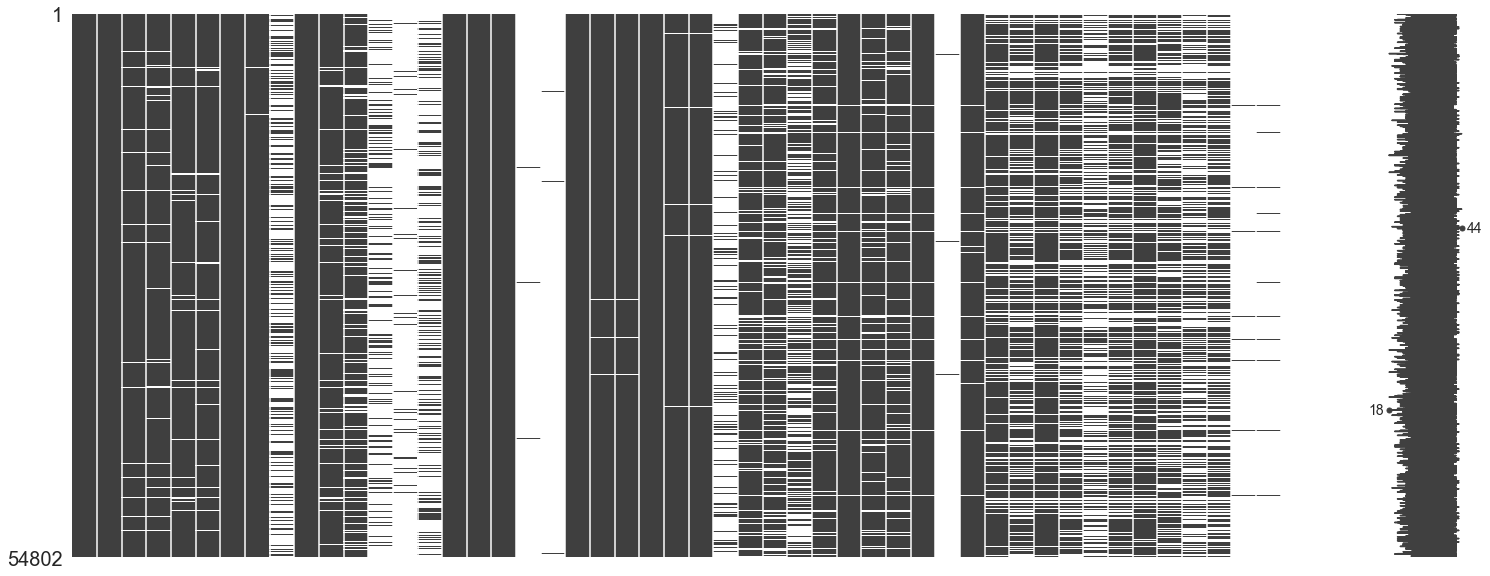

In [18]:
# checking if any pattern exists in newly transformed NAN values
msno.matrix(train)

In [19]:
print('\033[1m', 'All 50 columns', '\033[0m')
print('\033[1m', 'These', sum(train.isnull().mean().round(5) > 0.5),
      'columns have > 50% missing values', '\033[0m')
print(train.columns[train.isnull().mean().round(5) > 0.5].tolist())
print('')
raw_null_above50 = train[train.columns[train.isnull().mean().round(5) > 0.5].tolist()]
print(raw_null_above50.isnull().mean().round(5))
print('')
# Subset the data to include the columns only with nulls in the output
train_with_null = train[train.columns[train.isnull().any()].tolist()]
print('\033[1m', 'These', len(train_with_null.columns),
      'columns have any missing values', '\033[0m')
train_with_null.isnull().mean().round(5)

 All 50 columns 
 These 14 columns have > 50% missing values 
['LANE_CNT', 'INTERSECTION_RELATED_I', 'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DOORING_I', 'WORK_ZONE_I', 'NUM_PASSENGERS', 'EXCEED_SPEED_LIMIT_I', 'SAFETY_EQUIPMENT', 'DRIVER_VISION', 'PEDPEDAL_ACTION', 'PEDPEDAL_VISIBILITY', 'BAC_RESULT VALUE', 'CELL_PHONE_USE']

LANE_CNT                  0.67016
INTERSECTION_RELATED_I    0.75691
NOT_RIGHT_OF_WAY_I        0.95883
HIT_AND_RUN_I             0.70238
DOORING_I                 0.99662
WORK_ZONE_I               0.99443
NUM_PASSENGERS            0.84501
EXCEED_SPEED_LIMIT_I      0.99715
SAFETY_EQUIPMENT          0.54288
DRIVER_VISION             0.50527
PEDPEDAL_ACTION           0.97907
PEDPEDAL_VISIBILITY       0.97597
BAC_RESULT VALUE          0.99807
CELL_PHONE_USE            0.99896
dtype: float64

 These 42 columns have any missing values 


TRAFFIC_CONTROL_DEVICE    0.02909
DEVICE_CONDITION          0.05237
WEATHER_CONDITION         0.03834
LIGHTING_CONDITION        0.03212
TRAFFICWAY_TYPE           0.00878
LANE_CNT                  0.67016
ROADWAY_SURFACE_COND      0.06027
ROAD_DEFECT               0.13824
INTERSECTION_RELATED_I    0.75691
NOT_RIGHT_OF_WAY_I        0.95883
HIT_AND_RUN_I             0.70238
DOORING_I                 0.99662
WORK_ZONE_I               0.99443
MOST_SEVERE_INJURY        0.00210
INJURIES_TOTAL            0.00208
LATITUDE                  0.00553
LONGITUDE                 0.00553
NUM_PASSENGERS            0.84501
LIC_PLATE_STATE           0.10591
VEHICLE_YEAR              0.18196
VEHICLE_DEFECT            0.42796
VEHICLE_TYPE              0.11520
VEHICLE_USE               0.02688
TRAVEL_DIRECTION          0.09691
MANEUVER                  0.09945
OCCUPANT_CNT              0.02688
EXCEED_SPEED_LIMIT_I      0.99715
FIRST_CONTACT_POINT       0.03465
PERSON_TYPE               0.13861
CITY          

In [20]:
# Filing NaN values after multiple tests

train.fillna({
    'TRAFFIC_CONTROL_DEVICE': 'NO CONTROLS',
    'DEVICE_CONDITION': 'NO CONTROLS',
    'WEATHER_CONDITION': 'CLEAR',
    'LIGHTING_CONDITION': 'DAYLIGHT',
    'TRAFFICWAY_TYPE': 'NOT DIVIDED',
    'ROADWAY_SURFACE_COND': 'NO DEFECTS',
    'ROAD_DEFECT': 'CLEAR',
    'INTERSECTION_RELATED_I': 'N',
    
    'NOT_RIGHT_OF_WAY_I': 'N',
    'HIT_AND_RUN_I': 'N',
    'DOORING_I': 'N',
    'WORK_ZONE_I': 'N',
    'NUM_PASSENGERS': 0,
    'LIC_PLATE_STATE': 'IL',
    'VEHICLE_DEFECT': 'UNABLE TO DETERMINE',
    'VEHICLE_TYPE': 'OTHER',
    
    'VEHICLE_USE': 'OTHER',
    'TRAVEL_DIRECTION': 'N',
    'MANEUVER': 'OTHER',
    'OCCUPANT_CNT': 0,
    'EXCEED_SPEED_LIMIT_I': 'N',
    'FIRST_CONTACT_POINT': 'OTHER',
    'PERSON_TYPE': 'UNABLE TO DETERMINE',
    'CITY': 'OTHER',
    
    'SEX': 'UNABLE TO DETERMINE',
    'AIRBAG_DEPLOYED': 'UNABLE TO DETERMINE',
    'EJECTION': 'UNABLE TO DETERMINE',
    'DRIVER_ACTION': 'OTHER',
    'DRIVER_VISION': 'OTHER',
    'PHYSICAL_CONDITION': 'UNABLE TO DETERMINE',
    'PEDPEDAL_ACTION': 'UNABLE TO DETERMINE',
    'PEDPEDAL_VISIBILITY': 'UNABLE TO DETERMINE',
    
    'CELL_PHONE_USE': 'UNABLE TO DETERMINE',
    'SAFETY_EQUIPMENT': 'UNABLE TO DETERMINE',
    'BAC_RESULT VALUE': 0
}, inplace=True)

#### Replace with frequency (mode):
“LANE_CNT”: 30,763 missing data. Replace them with mode “2”

In [21]:
train['LANE_CNT'].fillna("2",inplace=True)

#### Drop the missing row


In [22]:
drop_rows = ['INJURIES_TOTAL', 'LATITUDE','MOST_SEVERE_INJURY']
train.dropna(how='any', subset=drop_rows, inplace = True)
train.isnull().sum()

CRASH_DATE                     0
POSTED_SPEED_LIMIT             0
TRAFFIC_CONTROL_DEVICE         0
DEVICE_CONDITION               0
WEATHER_CONDITION              0
LIGHTING_CONDITION             0
FIRST_CRASH_TYPE               0
TRAFFICWAY_TYPE                0
LANE_CNT                       0
ALIGNMENT                      0
ROADWAY_SURFACE_COND           0
ROAD_DEFECT                    0
INTERSECTION_RELATED_I         0
NOT_RIGHT_OF_WAY_I             0
HIT_AND_RUN_I                  0
PRIM_CONTRIBUTORY_CAUSE        0
SEC_CONTRIBUTORY_CAUSE         0
STREET_DIRECTION               0
DOORING_I                      0
WORK_ZONE_I                    0
NUM_UNITS                      0
MOST_SEVERE_INJURY             0
INJURIES_TOTAL                 0
CRASH_HOUR                     0
LATITUDE                       0
LONGITUDE                      0
NUM_PASSENGERS                 0
LIC_PLATE_STATE                0
VEHICLE_YEAR                9920
VEHICLE_DEFECT                 0
VEHICLE_TY

# Handling Outliers 

##  Categorical Features

Example 1: A, B, C, X.

Example 2: Apple, Orange, Pear or Blueberry, Raspberry, Strawberry, Grape.

"*The fact is **no outlier** exists in the examples above, for an outlier to exist there must be **a measure of distance**. This is intrinsic to numeric data types because there is a Euclidean distance between numbers.*"

**Categorical Outliers don’t exist without a context.**

> "*Techniques like **string indexing** or **one-hot encoding** on a categorical value to convert it from a string value to a numeric value and then use k-means clustering to find outliers.*"

> "*the numeric vector assigned to the String value during the one hot encoding practice still lacks **the domain context**. It does satisfy the input constraint of the k-means model and the model will produce an output. However the output will not select the appropriate outlier, as the input **was not truly valid**.*"

> "*There is an alternative. **K-modes** is designed to handle categorical values without the need for String Indexing or One Hot Encoding.*"

##  Numerical Features

**`LANE_CNT`**

**Outlier Identification**

- 3 rows of 9
- 13 rows of 10
- 1 row of 11
- 4 rows of 12
- 2 rows of 99

According to Chicago's roadway, 6 should be a maximum number for lanes

**Decision** to replace outlier with 6 lanes

In [23]:
train['LANE_CNT']=pd.to_numeric(train['LANE_CNT'])
train['VEHICLE_YEAR']=pd.to_numeric(train['VEHICLE_YEAR'])
train['NUM_UNITS']=pd.to_numeric(train['NUM_UNITS'])
train["POSTED_SPEED_LIMIT"]=pd.to_numeric(train["POSTED_SPEED_LIMIT"])
train["AGE"]=pd.to_numeric(train["AGE"])

In [24]:
# Change all rows with value greater than 6 to 6
train.loc[(train['LANE_CNT'] > 6),'LANE_CNT'] = 6
train.loc[(train['LANE_CNT'] == 0),'LANE_CNT'] = 1
train['LANE_CNT'].value_counts()

2    44921
4     4408
1     3513
3      769
6      575
5      202
Name: LANE_CNT, dtype: int64

# Feature Engineering

##  Target Feature Engineering

Pick **`INJURIES_TOTAL`** as a numerical target and/or encode **`INJURY`** as a categorical target.

- `INJURY`: Total persons sustaining **fatal, incapacitating, non-incapacitating** as determined by the reporting officer.

13% Injuries, 87% Non-injuries

Removing NAs from INJURIES_TOTAL below

In [25]:
train["MOST_SEVERE_INJURY"].unique()

array(['NO INDICATION OF INJURY', 'NONINCAPACITATING INJURY',
       'INCAPACITATING INJURY', 'REPORTED, NOT EVIDENT', 'FATAL'],
      dtype=object)

In [26]:
def injury(x): 
    if any(s in x for s in ["FATAL","NONINCAPACITATING INJURY","INCAPACITATING INJURY"]):
        return "INJURED"
    else:
        return "NOT INJURED"
    
# replacing NA values with OTHER
train["INJURY"] = train["MOST_SEVERE_INJURY"].apply(lambda x: injury(x))
#train.drop("MOST_SEVERE_INJURY", axis=1, inplace=True)

In [27]:
def fatalities(x): 
    if any(s in x for s in ["FATAL"]):
        return "FATAL"
    else:
        return "NOT FATAL"
    
# replacing NA values with OTHER
train["FATALITIES"] = train["MOST_SEVERE_INJURY"].apply(lambda x: fatalities(x))
train.drop("MOST_SEVERE_INJURY", axis=1, inplace=True)

In [28]:
train["INJURY"].value_counts()

NOT INJURED    48496
INJURED         5892
Name: INJURY, dtype: int64

In [29]:
train["FATALITIES"].value_counts()

NOT FATAL    54324
FATAL           64
Name: FATALITIES, dtype: int64

##  Other Feature Engineering / Adaptation

### CONTACT_POINT

Reduced # of layers in `FIRST_CONTACT_POINT` to:
- FRONT
- SIDE
- READ
- OTHER

In [30]:
def contact_point(x):
    if "FRONT" in x:
        return "FRONT"
    elif "SIDE" in x:
        return "SIDE"
    elif "REAR" in x:
        return "REAR"
    else:
        return "OTHER"
    
# replacing NA values with OTHER
train["FIRST_CONTACT_POINT"] = train["FIRST_CONTACT_POINT"].apply(lambda x: contact_point(x))

### MANEUVER, VEHICLE_YEAR, POSTED_SPEED_LIMIT

Reduced # of layers in `MANEUVER` to:
- UNKNOWN/NA
- TURN
- LANE
- OTHER


In [31]:
# merging same type of Maneuver in one
train["MANEUVER"] = train["MANEUVER"].apply(lambda x: "TURN" if "TURN" in x else("LANE" if any(s in x for s in ["LANE","OVER","ENTER"]) else x))
train["MANEUVER"] = train["MANEUVER"].apply(lambda x: "OTHER" if all(s not in x for s in ["AHEAD","TURN","UNKNOWN","LANE","BACKING"]) else x)

# converting VEHICLE_YEAR into new category of OLD or NEW
#train["VEHICLE_YEAR"]= train["VEHICLE_YEAR"].apply(lambda x: "UNKNOWN" if pd.isnull(x) else ("OLD (<2010)" if int(x)<2010 else "NEW"))

# converting POSTED_SPEED_LIMIT into new category of LOW SPEED or HIGH SPEED
#train["POSTED_SPEED_LIMIT"]=train["POSTED_SPEED_LIMIT"].apply(lambda x: "LOW_SPEED" if int(x)<=30 else "HIGH_SPEED")

### SAFETY_EQUIPMENT, AIRBAG_DEPLOYED

Reduced # of layers in `SAFETY_EQUIPMENT` to:
- USED SAFETY EQUIPMENT
- DID NOT USE SAFETY EQUIPMENT

Reduced # of layers in `AIRBAG_DEPLOYED` to:
- DEPLOYED
- NOT DEPLOYED

In [32]:
# grouping the SAFETY_EQUIPMENT used as SAFE and UNSAFE
def equip_used(x):
    if ("USED" in x) or ("HELMET" in x) or ("NONE PRESENT" in x):
        if any(s in x for s in ["NOT","IMPROPER","NONE PRESENT"]):
            return "DID NOT USE SAFETY EQUIP"
        else:
            return "USED SAFETY EQUIP"
    else:
        return x

train["SAFETY_EQUIPMENT"]= train["SAFETY_EQUIPMENT"].apply(lambda x: equip_used(x))


# grouping the AIRBAG_DEPLOYED used as DEPLOYED and NOT DEPLOYED
def airbag(x):
    if ("DEPLOY" in x) and ("UNKNOWN" not in x):
        if "NOT" in x:
            return "NOT DEPLOYED"
        else:
            return "DEPLOYED"
    else:
        return x
 
train["AIRBAG_DEPLOYED"]= train["AIRBAG_DEPLOYED"].apply(lambda x: airbag(x))

### CRASH_HOUR

Transform the crash hour to 4 categories:
- Early morning
- Morning
- Afternoon
- Night

In [33]:
def crash_hour(x):
    if  2 <= x < 8:
        return "Early_morning"
    elif 8 <= x < 12:
        return "Morning"
    elif 12 <= x < 18:
        return "Afternoon"
    else:
        return "Night"
    
# replacing NA values with OTHER
train["CRASH_HOUR"] = train["CRASH_HOUR"].apply(lambda x: crash_hour(int(x)))

### TRAFFIC_CONTROL_DEVICE

Transform the signs
- 'TRAFFIC SIGNAL', 'STOP SIGN/FLASHER', 'LANE USE MARKING', 'YIELD', 'DELINEATORS', 
'OTHER REG. SIGN', 'OTHER WARNING SIGN', 'POLICE/FLAGMAN', 'RAILROAD CROSSING GATE', 
'OTHER RAILROAD CROSSING', 'FLASHING CONTROL SIGNAL', 'PEDESTRIAN CROSSING SIGN',
'NO PASSING', 'SCHOOL ZONE', 'BICYCLE CROSSING SIGN' as `SIGN`
    
- 'NO CONTROLS','UNKNOWN', 'OTHER' as `NO_SIGN`

In [34]:
def traffic_control(x):
    if ("NO CONTROLS" in x) or ("UNKNOWN" in x) or ("OTHER" in x):
        return "NO_SIGN"
    else:
        return "SIGN"

train["TRAFFIC_CONTROL_DEVICE"]= train["TRAFFIC_CONTROL_DEVICE"].apply(lambda x: traffic_control(x))

### TRAFFICWAY_TYPE

In [35]:
def traffic_way(x):
    if ("NOT" in x) or ("ONE-WAY" in x):
        return "NOT_DIVIDED"
    else:
        return "DIVIDED"

train["TRAFFICWAY_TYPE"]= train["TRAFFICWAY_TYPE"].apply(lambda x: traffic_way(x))

### LOCATION

In [36]:
def location(x1,x2):
    if (41.84 <= float(x1) <= 41.9100064) and (-87.7421459 <= float(x2) <= -87.50):
        return "Downtown"
    else:
        return "Not Downtown"

#df['col_3'] = df.apply(lambda x: f(x.col_1, x.col_2), axis=1)
train["Location"] = train.apply(lambda x: location(x["LATITUDE"],x["LONGITUDE"]), axis=1)

In [37]:
train["Location"].value_counts()

Not Downtown    39902
Downtown        14486
Name: Location, dtype: int64

### PRIM and SEC cause 

In [38]:
#dict_prim = {'DISREGARDING TRAFFIC SIGNALS' : 'IMPROPER ACTION BY THE DRIVER', 'IMPROPER OVERTAKING/PASSING' : 'IMPROPER ACTION BY THE DRIVER',
#            'ROAD CONSTRUCTION/MAINTENANCE' : 'EXTERNAL FORESEEABLE', 'nan' : np.nan, 'IMPROPER TURNING/NO SIGNAL' : 'IMPROPER ACTION BY THE DRIVER',
#            'FOLLOWING TOO CLOSELY' : 'IMPROPER ACTION BY THE DRIVER', 'DISTRACTION - FROM INSIDE VEHICLE' : 'IMPROPER ACTION BY THE DRIVER',
#            'IMPROPER BACKING' : 'IMPROPER ACTION BY THE DRIVER', 'IMPROPER LANE USAGE': 'IMPROPER ACTION BY THE DRIVER',
#            'FAILING TO YIELD RIGHT-OF-WAY' : 'IMPROPER ACTION BY THE DRIVER', 'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE' : 'DRIVING QUALIFICATION',
#            'DISREGARDING STOP SIGN' : 'IMPROPER ACTION BY THE DRIVER', 'NOT APPLICABLE' : np.nan, 'FAILING TO REDUCE SPEED TO AVOID CRASH' : 'DRIVING QUALIFICATION',
#            'DISREGARDING ROAD MARKINGS' : 'EXTERNAL FORESEEABLE', 'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER' : 'IMPROPER ACTION BY THE DRIVER',
#            'DISTRACTION - FROM OUTSIDE VEHICLE' : 'EXTERNAL UNFORSEEABLE', 'EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST' : 'EXTERNAL UNFORSEEABLE',
#            'UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)' : 'IMPROPER ACTION BY THE DRIVER',
#            'WEATHER' : 'EXTERNAL FORESEEABLE', 'DRIVING ON WRONG SIDE/WRONG WAY' : 'DRIVING QUALIFICATION', 'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)' : 'EXTERNAL UNFORSEEABLE',
#            'EXCEEDING AUTHORIZED SPEED LIMIT' : 'IMPROPER ACTION BY THE DRIVER', 'EXCEEDING SAFE SPEED FOR CONDITIONS': 'IMPROPER ACTION BY THE DRIVER',
#            'PHYSICAL CONDITION OF DRIVER' : 'DRIVING QUALIFICATION', 'DISREGARDING OTHER TRAFFIC SIGNS' : 'IMPROPER ACTION BY THE DRIVER',
#            'EQUIPMENT - VEHICLE CONDITION' : 'EXTERNAL FORESEEABLE', 'RELATED TO BUS STOP' : 'EXTERNAL FORESEEABLE', 'CELL PHONE USE OTHER THAN TEXTING' : 'IMPROPER ACTION BY THE DRIVER',
#            'MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT' : 'IMPROPER ACTION BY THE DRIVER', 'PASSING STOPPED SCHOOL BUS' : 'IMPROPER ACTION BY THE DRIVER',
#            'ROAD ENGINEERING/SURFACE/MARKING DEFECTS' : 'EXTERNAL FORESEEABLE', 'HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)' : 'IMPROPER ACTION BY THE DRIVER',
#            'TEXTING' : 'IMPROPER ACTION BY THE DRIVER', 'DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)' : 'EXTERNAL FORESEEABLE',
#            'TURNING RIGHT ON RED' : 'IMPROPER ACTION BY THE DRIVER', 'DISREGARDING YIELD SIGN' : 'IMPROPER ACTION BY THE DRIVER',
#            'ANIMAL' : 'EXTERNAL UNFORSEEABLE', 'BICYCLE ADVANCING LEGALLY ON RED LIGHT' : 'EXTERNAL UNFORSEEABLE'}

In [39]:
#train['PRIM_CONTRIBUTORY_CAUSE'] = train["PRIM_CONTRIBUTORY_CAUSE"].map(dict_prim)

In [40]:
#dict_sec = {'FAILING TO YIELD RIGHT-OF-WAY' : 'IMPROPER ACTION BY THE DRIVER', 'nan' : np.nan, 'NOT APPLICABLE' : np.nan,
#           'DISTRACTION - FROM INSIDE VEHICLE' : 'EXTERNAL FORSEEABLE', 'IMPROPER OVERTAKING/PASSING' : 'IMPROPER ACTION BY THE DRIVER',
#           'FAILING TO REDUCE SPEED TO AVOID CRASH' : 'IMPROPER ACTION BY THE DRIVER', 'IMPROPER LANE USAGE' : 'IMPROPER ACTION BY THE DRIVER',
#           'EXCEEDING SAFE SPEED FOR CONDITIONS' : 'IMPROPER ACTION BY THE DRIVER', 'IMPROPER TURNING/NO SIGNAL' : 'IMPROPER ACTION BY THE DRIVER',
#           'FOLLOWING TOO CLOSELY' : 'DRIVING QUALIFICATION', 'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE' : 'DRIVING QUALIFICATION',
#           'WEATHER' : 'EXTERNAL FORSEEABLE', 'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER' : 'IMPROPER ACTION BY THE DRIVER',
#           'DISTRACTION - FROM OUTSIDE VEHICLE' : 'EXTERNAL UNFORSEEABLE', 'DISREGARDING STOP SIGN' : 'IMPROPER ACTION BY THE DRIVER',
#           'CELL PHONE USE OTHER THAN TEXTING' : 'IMPROPER ACTION BY THE DRIVER', 'PHYSICAL CONDITION OF DRIVER' : 'DRIVING QUALIFICATION',
#           'IMPROPER BACKING' : 'IMPROPER ACTION BY THE DRIVER', 'EXCEEDING AUTHORIZED SPEED LIMIT' : 'IMPROPER ACTION BY THE DRIVER',
#           'DISREGARDING TRAFFIC SIGNALS' : 'IMPROPER ACTION BY THE DRIVER', 'UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)': 'IMPROPER ACTION BY THE DRIVER',
#           'DRIVING ON WRONG SIDE/WRONG WAY' : 'DRIVING QUALIFICATION', 'HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)': 'IMPROPER ACTION BY THE DRIVER',
#           'ROAD CONSTRUCTION/MAINTENANCE' : 'EXTERNAL FORSEEABLE', 'EQUIPMENT - VEHICLE CONDITION' : 'EXTERNAL UNFORSEEABLE',
#           'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)' : 'EXTERNAL UNFORSEEABLE', 'TURNING RIGHT ON RED' : 'IMPROPER ACTION BY THE DRIVER',
#           'DISREGARDING ROAD MARKINGS' : 'IMPROPER ACTION BY THE DRIVER', 'DISREGARDING OTHER TRAFFIC SIGNS' : 'IMPROPER ACTION BY THE DRIVER',
#           'BICYCLE ADVANCING LEGALLY ON RED LIGHT' : 'EXTERNAL UNFORSEEABLE', 'ROAD ENGINEERING/SURFACE/MARKING DEFECTS' : 'EXTERNAL UNFORSEEABLE',
#           'RELATED TO BUS STOP' : 'DRIVING QUALIFICATION', 'DISREGARDING YIELD SIGN' : 'IMPROPER ACTION BY THE DRIVER', 'OBSTRUCTED CROSSWALKS' : 'IMPROPER ACTION BY THE DRIVER',
#           'ANIMAL' : 'EXTERNAL UNFORSEEABLE', 'DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)' : 'EXTERNAL FORSEEABLE',
#          'EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST' : 'EXTERNAL UNFORSEEABLE', 'TEXTING' : 'IMPROPER ACTION BY THE DRIVER', 'MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT' : 'IMPROPER ACTION BY THE DRIVER',
#          'PASSING STOPPED SCHOOL BUS' : 'IMPROPER ACTION BY THE DRIVER'}


In [41]:
#train['SEC_CONTRIBUTORY_CAUSE'] = train["SEC_CONTRIBUTORY_CAUSE"].map(dict_sec)

### CAR AGE

In [42]:
train["VEHICLE_AGE"]=train["CRASH_DATE"].dt.year-train["VEHICLE_YEAR"]

In [43]:
train.loc[train["VEHICLE_AGE"]<0,"VEHICLE_AGE"]=0

In [44]:
train.drop("VEHICLE_YEAR",axis=1,inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54388 entries, 29244 to 15795
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   CRASH_DATE               54388 non-null  datetime64[ns]
 1   POSTED_SPEED_LIMIT       54388 non-null  int64         
 2   TRAFFIC_CONTROL_DEVICE   54388 non-null  object        
 3   DEVICE_CONDITION         54388 non-null  object        
 4   WEATHER_CONDITION        54388 non-null  object        
 5   LIGHTING_CONDITION       54388 non-null  object        
 6   FIRST_CRASH_TYPE         54388 non-null  object        
 7   TRAFFICWAY_TYPE          54388 non-null  object        
 8   LANE_CNT                 54388 non-null  int64         
 9   ALIGNMENT                54388 non-null  object        
 10  ROADWAY_SURFACE_COND     54388 non-null  object        
 11  ROAD_DEFECT              54388 non-null  object        
 12  INTERSECTION_RELATED_I   543

# Modeling

## Random Forest -Classifier (All Post-Crash Categories)

In [ ]:
# removing below columns
drop_list=["LATITUDE","LONGITUDE","INJURIES_TOTAL","CRASH_DATE"]

train_new_class = train.drop(drop_list, axis=1)

In [166]:
# splitting the dataset into x_train and y_train
X_train = train_new_class.drop(["INJURY"],axis=1).reset_index(drop=True)
#y_train = train_new_class["INJURY"]

In [169]:
#X_train.isnull().sum()

In [170]:
# performing one hot encoding on all the object features
X_train = pd.get_dummies(X_train, columns=X_train.select_dtypes(['object']).columns, drop_first=True)

In [171]:
y_train = train_new["INJURY"]
y_train_new = (y_train == "INJURED")
y_train_new=y_train_new.astype(int)

In [173]:
#Create a Random Forest Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
scores = cross_val_score(clf, X_train, y_train_new, cv=5)
print('Accuracy', np.mean(scores), scores)

Accuracy 0.9079576753909224 [0.91046148 0.90623276 0.90512962 0.9083387  0.90962582]


In [174]:
recall = cross_val_score(clf, X_train, y_train_new, cv=5, scoring='recall')
print('Recall', np.mean(recall), recall)
precision = cross_val_score(clf, X_train, y_train_new, cv=5, scoring='precision')
print('Precision', np.mean(precision), precision)
f1 = cross_val_score(clf, X_train, y_train_new, cv=5, scoring='f1')
print('F1', np.mean(f1), f1)

Recall 0.21079718503350225 [0.22665535 0.20101781 0.20356234 0.20543294 0.21731749]
Precision 0.7730519539337115 [0.79510703 0.74774775 0.746875   0.78187919 0.79365079]
F1 0.3282971841410609 [0.36886854 0.30727763 0.30417227 0.32227488 0.3388926 ]


[0.01563293 0.01239206 0.02344322 ... 0.00014888 0.00253842 0.01062077]


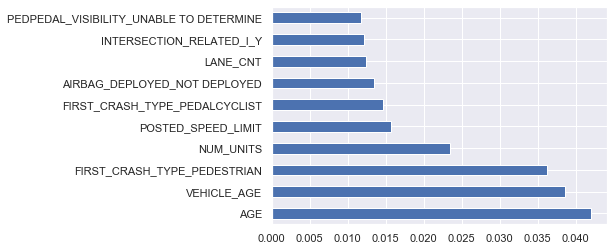

In [175]:
#Create a Random Forest Classifier
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train_new)
print(clf.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [176]:
feat_importances.nlargest(50)

AGE                                                      0.041946
VEHICLE_AGE                                              0.038532
FIRST_CRASH_TYPE_PEDESTRIAN                              0.036155
NUM_UNITS                                                0.023443
POSTED_SPEED_LIMIT                                       0.015633
FIRST_CRASH_TYPE_PEDALCYCLIST                            0.014654
AIRBAG_DEPLOYED_NOT DEPLOYED                             0.013481
LANE_CNT                                                 0.012392
INTERSECTION_RELATED_I_Y                                 0.012153
PEDPEDAL_VISIBILITY_UNABLE TO DETERMINE                  0.011750
STREET_DIRECTION_W                                       0.011187
TRAFFICWAY_TYPE_NOT DIVIDED                              0.010958
SEX_M                                                    0.010843
STREET_DIRECTION_S                                       0.010795
SEC_CONTRIBUTORY_CAUSE_NOT APPLICABLE                    0.010636
Location_N

## Random Forest - Regressor (All Post-Crash Categories)

In [ ]:
# removing below columns
drop_list=["LATITUDE","LONGITUDE","INJURY","CRASH_DATE"]

train_new_reg = train.drop(drop_list, axis=1)

In [ ]:
# splitting the dataset into x_train and y_train
X_train = train_new_reg.drop(["INJURIES_TOTAL"],axis=1)
y_train = train_new_reg["INJURIES_TOTAL"]

In [ ]:
#X_train.info()

In [ ]:
# performing one hot encoding on all the object features
X_train = pd.get_dummies(X_train, columns=X_train.select_dtypes(['object']).columns, drop_first=True)

In [ ]:
X_train.head()

In [ ]:
#Create a Random Forest Classifier
#clf=RandomForestRegressor()

#Train the model using the training sets y_pred=clf.predict(X_test)
#scores = cross_val_score(clf, X_train, y_train, cv=5)
#print('mean_squared_error', np.mean(scores), scores)

In [ ]:
#Create a Random Forest Classifier
clf=RandomForestRegressor()
clf.fit(X_train,y_train)
print(clf.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [ ]:
feat_importances.nlargest(50)

# Sprint 4

## Random Forest -Classifier (INJURIES)

In [164]:
filter_list=["AGE","LANE_CNT","AIRBAG_DEPLOYED","PRIM_CONTRIBUTORY_CAUSE","POSTED_SPEED_LIMIT","NUM_UNITS","TRAFFICWAY_TYPE",  
             "SEC_CONTRIBUTORY_CAUSE","VEHICLE_AGE","FIRST_CRASH_TYPE","INJURY","LIGHTING_CONDITION","SEX"]

train_new = train[filter_list]

In [165]:
# splitting the dataset into x_train and y_train
X_train = train_new.drop(["INJURY"],axis=1)
y_train = train_new["INJURY"]

In [166]:
# performing one hot encoding on all the object features
X_train = pd.get_dummies(X_train, columns=X_train.select_dtypes(['object']).columns)

In [167]:
dummies_to_drop = X_train.columns[X_train.columns.str.contains("UNABLE|UNKNOWN|NOT APPLICABLE|OTHER")]
X_train = X_train.loc[:, ~X_train.columns.isin(dummies_to_drop)]

In [169]:
#X_train.info()

In [52]:
#from sklearn.impute import KNNImputer
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
df = pd.DataFrame(imputer.fit_transform(X_train),columns = X_train.columns)
X_train=df.copy()
X_train=np.round(X_train)

In [53]:
train.reset_index(drop=True,inplace=True)
train[["AGE","VEHICLE_AGE"]]=X_train[["AGE","VEHICLE_AGE"]]

In [170]:
y_train = train_new["INJURY"]
y_train_new = (y_train == "INJURED")
y_train_new=y_train_new.astype(int)
#Encode the y_train labels
#lb = preprocessing.LabelBinarizer()
#y_train=lb.fit_transform(y_train)

In [55]:
#y_train_new

In [56]:
#Create a Random Forest Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
scores = cross_val_score(clf, X_train, y_train_new, cv=5)
print('Accuracy', np.mean(scores), scores)

Accuracy 0.9142090036743238 [0.91680456 0.91321934 0.91331127 0.91137262 0.91633723]


In [57]:
recall = cross_val_score(clf, X_train, y_train_new, cv=5, scoring='recall')
print('Recall', np.mean(recall), recall)
precision = cross_val_score(clf, X_train, y_train_new, cv=5, scoring='precision')
print('Precision', np.mean(precision), precision)
f1 = cross_val_score(clf, X_train, y_train_new, cv=5, scoring='f1')
print('F1', np.mean(f1), f1)

Recall 0.36829749823956587 [0.3820034  0.3562341  0.37150127 0.35059423 0.3811545 ]
Precision 0.6987729512901684 [0.7221374  0.68881686 0.68495298 0.69384359 0.70411392]
F1 0.4821829616877927 [0.50744622 0.46883618 0.47876448 0.45971831 0.49614961]


[1.74045496e-01 3.23146255e-02 4.19475767e-02 4.49379938e-02
 1.38556562e-01 4.53551527e-02 1.86670261e-02 5.28123551e-04
 1.30536054e-04 7.24205407e-04 3.93162257e-03 7.60747671e-03
 2.93425465e-04 2.56191984e-03 2.53448732e-03 2.34872834e-03
 5.33288128e-03 1.75088710e-03 7.00355279e-04 2.90554705e-03
 1.62783930e-03 1.04861726e-02 1.22730211e-02 7.71741580e-03
 9.05748579e-04 2.70788280e-03 4.38858522e-03 4.93894594e-03
 4.79940392e-03 4.06026140e-04 4.52525443e-03 1.50317815e-06
 6.80184000e-03 4.25139069e-04 4.68248374e-04 6.78272372e-04
 6.91325210e-05 2.77578804e-04 3.15692386e-03 2.14977853e-03
 3.68571427e-03 1.26107600e-02 1.21703554e-02 1.21624727e-04
 1.68751803e-04 1.42723498e-03 1.66674706e-03 3.18495460e-03
 5.23857125e-04 1.68659256e-03 1.32067479e-03 1.91406593e-03
 8.06318266e-03 1.07497270e-03 5.76292656e-05 2.93277177e-03
 1.34745183e-03 1.04205661e-02 7.91101682e-03 4.40930600e-03
 6.27884213e-04 6.53835412e-04 3.10855549e-03 2.71933887e-03
 2.81656949e-03 4.064665

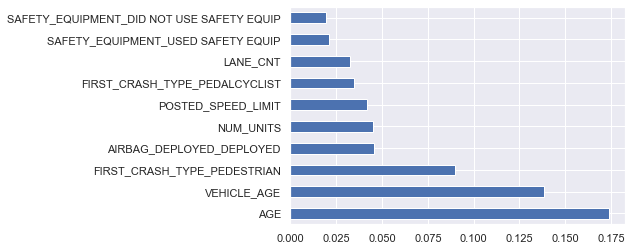

In [58]:
#Create a Random Forest Classifier
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train_new)
print(clf.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [59]:
feat_importances.nlargest(50)

AGE                                                                                                         0.174045
VEHICLE_AGE                                                                                                 0.138557
FIRST_CRASH_TYPE_PEDESTRIAN                                                                                 0.090047
AIRBAG_DEPLOYED_DEPLOYED                                                                                    0.045355
NUM_UNITS                                                                                                   0.044938
POSTED_SPEED_LIMIT                                                                                          0.041948
FIRST_CRASH_TYPE_PEDALCYCLIST                                                                               0.034479
LANE_CNT                                                                                                    0.032315
SAFETY_EQUIPMENT_USED SAFETY EQUIP                              

## Checking other models

In [61]:
def evaluate_model(model, X_, y_):
    score_cols = ['Metric','Accuracy','Precision', 'Recall', 'F1 Score', 'AUC']
    score_df = pd.DataFrame(columns=score_cols)
    
    model_name = model.__class__.__name__
    accuracy_lst = []
    precision_lst = []
    recall_lst = []
    f1_lst = []
    auc_lst = []
    
    cv = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
    for train_index, test_index in cv.split(X_,y_):   
        X_train, X_test = X_.iloc[train_index], X_.iloc[test_index]
        y_train, y_test = y_.iloc[train_index], y_.iloc[test_index]
        
        model.fit(X_train, y_train)
        prediction = model.predict(X_test)
        accuracy_lst.append(accuracy_score(y_test,prediction))
        precision_lst.append(precision_score(y_test,prediction))
        recall_lst.append(recall_score(y_test,prediction))
        f1_lst.append(f1_score(y_test,prediction))
        auc_lst.append(roc_auc_score(y_test, prediction))

    score_df.loc[0,'Metric'] = model_name
    score_df.loc[0,'Accuracy'] = '{0:0.3f}'.format(np.mean(accuracy_lst))
    score_df.loc[0,'Precision'] = '{0:0.3f}'.format(np.mean(precision_lst))
    score_df.loc[0,'Recall'] = '{0:0.3f}'.format(np.mean(recall_lst))
    score_df.loc[0,'F1 Score'] = '{0:0.3f}'.format(np.mean(f1_lst))
    score_df.loc[0,'AUC'] = '{0:0.3f}'.format(np.mean(auc_lst))
    return score_df

In [419]:
logreg = LogisticRegression()
logreg_noresampling = evaluate_model(logreg,X_train,y_train_new)

In [420]:
rfc = RandomForestClassifier()
rfc_noresampling = evaluate_model(rfc,X_train,y_train_new)

In [421]:
xgb = XGBClassifier()
xgb_noresampling=evaluate_model(xgb,X_train,y_train_new)

In [422]:
no_result = pd.concat([logreg_noresampling,rfc_noresampling,xgb_noresampling], axis=0)
no_result

Metric Accuracy Precision Recall F1 Score    AUC
0      LogisticRegression    0.909     0.655  0.337    0.445  0.658
0  RandomForestClassifier    0.915     0.699  0.380    0.492  0.680
0           XGBClassifier    0.915     0.693  0.388    0.497  0.683

### Undersampling

In [62]:
def evaluate_model_undersampling(model, X_, y_, resampling_rate):
    score_cols = ['Metric','Accuracy','Precision', 'Recall', 'F1 Score', 'AUC']
    score_df = pd.DataFrame(columns=score_cols)
    
    model_name = model.__class__.__name__
    accuracy_lst = []
    precision_lst = []
    recall_lst = []
    f1_lst = []
    auc_lst = []
    
    cv = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
    for train_index, test_index in cv.split(X_,y_):        
        X_train, X_test = X_.iloc[train_index], X_.iloc[test_index]
        y_train, y_test = y_.iloc[train_index], y_.iloc[test_index]
        
        X_train = X_train.values
        X_test = X_test.values
        y_train = y_train.values
        y_test = y_test.values
        
        under = RandomUnderSampler(sampling_strategy=resampling_rate)
        X_under, y_under = under.fit_resample(X_train, y_train)
        count = Counter(y_under)
        print(count)
        
        steps = [('u', under),('model', model)]
        pipeline = Pipeline(steps=steps)
        pipeline.fit(X_train, y_train)
        
        prediction = model.predict(X_test)
        accuracy_lst.append(accuracy_score(y_test,prediction))
        precision_lst.append(precision_score(y_test,prediction))
        recall_lst.append(recall_score(y_test,prediction))
        f1_lst.append(f1_score(y_test,prediction))
        auc_lst.append(roc_auc_score(y_test, prediction))
    score_df.loc[0,'Metric'] = model_name + ' ' + str(resampling_rate*100) + '%'
    score_df.loc[0,'Accuracy'] = '{0:0.3f}'.format(np.mean(accuracy_lst))
    score_df.loc[0,'Precision'] = '{0:0.3f}'.format(np.mean(precision_lst))
    score_df.loc[0,'Recall'] = '{0:0.3f}'.format(np.mean(recall_lst))
    score_df.loc[0,'F1 Score'] = '{0:0.3f}'.format(np.mean(f1_lst))
    score_df.loc[0,'AUC'] = '{0:0.3f}'.format(np.mean(auc_lst))
    return score_df

In [450]:
logreg = LogisticRegression()
logreg_under_maj = evaluate_model_undersampling(logreg,X_train,y_train_new,'majority')

Counter({0: 4714, 1: 4714})
Counter({0: 4713, 1: 4713})
Counter({0: 4713, 1: 4713})
Counter({0: 4714, 1: 4714})
Counter({0: 4714, 1: 4714})


In [444]:
logreg = LogisticRegression()
logreg_under_50 = evaluate_model_undersampling(logreg,X_train,y_train_new,0.5)

Counter({0: 9428, 1: 4714})
Counter({0: 9426, 1: 4713})
Counter({0: 9426, 1: 4713})
Counter({0: 9428, 1: 4714})
Counter({0: 9428, 1: 4714})


In [442]:
svm = SVC()
svm_under_maj =evaluate_model_undersampling(svm,X_train,y_train_new,'majority')

Counter({0: 4714, 1: 4714})
Counter({0: 4713, 1: 4713})
Counter({0: 4713, 1: 4713})
Counter({0: 4714, 1: 4714})
Counter({0: 4714, 1: 4714})


In [443]:
svm = SVC()
svm_under_50  = evaluate_model_undersampling(svm,X_train,y_train_new,0.5)

Counter({0: 9428, 1: 4714})
Counter({0: 9426, 1: 4713})
Counter({0: 9426, 1: 4713})
Counter({0: 9428, 1: 4714})
Counter({0: 9428, 1: 4714})


In [445]:
rfc = RandomForestClassifier()
rfc_under_maj = evaluate_model_undersampling(rfc,X_train,y_train_new,'majority')

Counter({0: 4714, 1: 4714})
Counter({0: 4713, 1: 4713})
Counter({0: 4713, 1: 4713})
Counter({0: 4714, 1: 4714})
Counter({0: 4714, 1: 4714})


In [446]:
rfc = RandomForestClassifier()
rfc_under_50 = evaluate_model_undersampling(rfc,X_train,y_train_new,0.5)

Counter({0: 9428, 1: 4714})
Counter({0: 9426, 1: 4713})
Counter({0: 9426, 1: 4713})
Counter({0: 9428, 1: 4714})
Counter({0: 9428, 1: 4714})


In [447]:
xgb = XGBClassifier()
xgb_under_maj = evaluate_model_undersampling(xgb,X_train,y_train_new,'majority')

Counter({0: 4714, 1: 4714})
Counter({0: 4713, 1: 4713})
Counter({0: 4713, 1: 4713})
Counter({0: 4714, 1: 4714})
Counter({0: 4714, 1: 4714})


In [448]:
xgb = XGBClassifier()
xgb_under_50 = evaluate_model_undersampling(xgb,X_train,y_train_new,0.5)

Counter({0: 9428, 1: 4714})
Counter({0: 9426, 1: 4713})
Counter({0: 9426, 1: 4713})
Counter({0: 9428, 1: 4714})
Counter({0: 9428, 1: 4714})


In [451]:
under_result = pd.concat([logreg_under_maj,logreg_under_50,
                         svm_under_maj,svm_under_50,
                         rfc_under_maj,rfc_under_50,
                         xgb_under_maj,xgb_under_50], axis=0)
under_result

Metric Accuracy Precision  \
0  LogisticRegression majoritymajoritymajoritymaj...    0.824     0.343   
0                           LogisticRegression 50.0%    0.890     0.492   
0  SVC majoritymajoritymajoritymajoritymajorityma...    0.746     0.248   
0                                          SVC 50.0%    0.895     0.603   
0  RandomForestClassifier majoritymajoritymajorit...    0.792     0.308   
0                       RandomForestClassifier 50.0%    0.878     0.453   
0  XGBClassifier majoritymajoritymajoritymajority...    0.804     0.319   
0                                XGBClassifier 50.0%    0.881     0.462   

  Recall F1 Score    AUC  
0  0.682    0.456  0.761  
0  0.565    0.526  0.747  
0  0.663    0.361  0.710  
0  0.081    0.143  0.537  
0  0.742    0.436  0.770  
0  0.618    0.523  0.764  
0  0.715    0.441  0.765  
0  0.603    0.523  0.759

### Oversampling - RandomOverSampling

In [63]:
def evaluate_model_oversampling_random(model, X_, y_, resampling_rate):
    score_cols = ['Metric','Accuracy','Precision', 'Recall', 'F1 Score', 'AUC']
    score_df = pd.DataFrame(columns=score_cols)
    
    model_name = model.__class__.__name__
    accuracy_lst = []
    precision_lst = []
    recall_lst = []
    f1_lst = []
    auc_lst = []
    
    cv = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
    for train_index, test_index in cv.split(X_,y_):        
        X_train, X_test = X_.iloc[train_index], X_.iloc[test_index]
        y_train, y_test = y_.iloc[train_index], y_.iloc[test_index]
        
        X_train = X_train.values
        X_test = X_test.values
        y_train = y_train.values
        y_test = y_test.values
        
        under = RandomOverSampler(sampling_strategy=resampling_rate)
        X_under, y_under = under.fit_resample(X_train, y_train)
        count = Counter(y_under)
        print(count)
        
        steps = [('u', under),('model', model)]
        pipeline = Pipeline(steps=steps)
        pipeline.fit(X_train, y_train)
        
        prediction = model.predict(X_test)
        accuracy_lst.append(accuracy_score(y_test,prediction))
        precision_lst.append(precision_score(y_test,prediction))
        recall_lst.append(recall_score(y_test,prediction))
        f1_lst.append(f1_score(y_test,prediction))
        auc_lst.append(roc_auc_score(y_test, prediction))
    score_df.loc[0,'Metric'] = model_name + ' ' + str(resampling_rate*100) + '%'
    score_df.loc[0,'Accuracy'] = '{0:0.3f}'.format(np.mean(accuracy_lst))
    score_df.loc[0,'Precision'] = '{0:0.3f}'.format(np.mean(precision_lst))
    score_df.loc[0,'Recall'] = '{0:0.3f}'.format(np.mean(recall_lst))
    score_df.loc[0,'F1 Score'] = '{0:0.3f}'.format(np.mean(f1_lst))
    score_df.loc[0,'AUC'] = '{0:0.3f}'.format(np.mean(auc_lst))
    return score_df

In [457]:
logreg = LogisticRegression()
logreg_over_maj = evaluate_model_oversampling_random(logreg,X_train,y_train_new,'minority')

Counter({0: 38796, 1: 38796})
Counter({0: 38797, 1: 38797})
Counter({0: 38797, 1: 38797})
Counter({0: 38797, 1: 38797})
Counter({0: 38797, 1: 38797})


In [458]:
logreg = LogisticRegression()
logreg_over_50 = evaluate_model_oversampling_random(logreg,X_train,y_train_new,0.5)

Counter({0: 38796, 1: 19398})
Counter({0: 38797, 1: 19398})
Counter({0: 38797, 1: 19398})
Counter({0: 38797, 1: 19398})
Counter({0: 38797, 1: 19398})


In [459]:
rfc = RandomForestClassifier()
rfc_over_maj = evaluate_model_oversampling_random(rfc,X_train,y_train_new,'minority')

Counter({0: 38796, 1: 38796})
Counter({0: 38797, 1: 38797})
Counter({0: 38797, 1: 38797})
Counter({0: 38797, 1: 38797})
Counter({0: 38797, 1: 38797})


In [460]:
rfc = RandomForestClassifier()
rfc_under_50 = evaluate_model_oversampling_random(rfc,X_train,y_train_new,0.5)

Counter({0: 38796, 1: 19398})
Counter({0: 38797, 1: 19398})
Counter({0: 38797, 1: 19398})
Counter({0: 38797, 1: 19398})
Counter({0: 38797, 1: 19398})


In [461]:
xgb = XGBClassifier()
xgb_over_maj = evaluate_model_oversampling_random(xgb,X_train,y_train_new,'minority')

Counter({0: 38796, 1: 38796})
Counter({0: 38797, 1: 38797})
Counter({0: 38797, 1: 38797})
Counter({0: 38797, 1: 38797})
Counter({0: 38797, 1: 38797})


In [462]:
xgb = XGBClassifier()
xgb_over_50 = evaluate_model_oversampling_random(xgb,X_train,y_train_new,0.5)

Counter({0: 38796, 1: 19398})
Counter({0: 38797, 1: 19398})
Counter({0: 38797, 1: 19398})
Counter({0: 38797, 1: 19398})
Counter({0: 38797, 1: 19398})


In [464]:
over_rand_result = pd.concat([logreg_over_maj,logreg_over_50,
                         rfc_over_maj,rfc_under_50,
                         xgb_over_maj,xgb_over_50], axis=0)
over_rand_result

Metric Accuracy Precision  \
0  LogisticRegression minorityminorityminoritymin...    0.826     0.346   
0                           LogisticRegression 50.0%    0.890     0.495   
0  RandomForestClassifier minorityminorityminorit...    0.907     0.591   
0                       RandomForestClassifier 50.0%    0.910     0.609   
0  XGBClassifier minorityminorityminorityminority...    0.851     0.391   
0                                XGBClassifier 50.0%    0.897     0.522   

  Recall F1 Score    AUC  
0  0.685    0.460  0.764  
0  0.563    0.527  0.747  
0  0.469    0.523  0.715  
0  0.470    0.530  0.716  
0  0.675    0.495  0.774  
0  0.577    0.548  0.757

### Oversampling - SMOTE

In [64]:
def evaluate_model_oversampling(model, X_, y_, resampling_rate):
    score_cols = ['Metric','Accuracy','Precision', 'Recall', 'F1 Score', 'AUC']
    score_df = pd.DataFrame(columns=score_cols)
    
    model_name = model.__class__.__name__
    accuracy_lst = []
    precision_lst = []
    recall_lst = []
    f1_lst = []
    auc_lst = []
    
    cv = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
    for train_index, test_index in cv.split(X_,y_):        
        X_train, X_test = X_.iloc[train_index], X_.iloc[test_index]
        y_train, y_test = y_.iloc[train_index], y_.iloc[test_index]
        
        X_train = X_train.values
        X_test = X_test.values
        y_train = y_train.values
        y_test = y_test.values
        
        over = SMOTE(sampling_strategy=resampling_rate)
        steps = [('o', over), ('model', model)]
        pipeline = Pipeline(steps=steps)
        pipeline.fit(X_train, y_train)
        
        prediction = model.predict(X_test)
        accuracy_lst.append(accuracy_score(y_test,prediction))
        precision_lst.append(precision_score(y_test,prediction))
        recall_lst.append(recall_score(y_test,prediction))
        f1_lst.append(f1_score(y_test,prediction))
        auc_lst.append(roc_auc_score(y_test, prediction))
    score_df.loc[0,'Metric'] = model_name + ' ' + str(resampling_rate*100) + '%'
    score_df.loc[0,'Accuracy'] = '{0:0.3f}'.format(np.mean(accuracy_lst))
    score_df.loc[0,'Precision'] = '{0:0.3f}'.format(np.mean(precision_lst))
    score_df.loc[0,'Recall'] = '{0:0.3f}'.format(np.mean(recall_lst))
    score_df.loc[0,'F1 Score'] = '{0:0.3f}'.format(np.mean(f1_lst))
    score_df.loc[0,'AUC'] = '{0:0.3f}'.format(np.mean(auc_lst))
    return score_df

In [466]:
logreg = LogisticRegression()
logreg_over_maj = evaluate_model_oversampling(logreg,X_train,y_train_new,'minority')

In [467]:
logreg = LogisticRegression()
logreg_over_50 = evaluate_model_oversampling(logreg,X_train,y_train_new,0.5)

In [469]:
rfc = RandomForestClassifier()
rfc_over_maj = evaluate_model_oversampling(rfc,X_train,y_train_new,'minority')

In [468]:
rfc = RandomForestClassifier()
rfc_over_50 = evaluate_model_oversampling(rfc,X_train,y_train_new,0.5)

In [470]:
xgb = XGBClassifier()
xgb_over_maj = evaluate_model_oversampling(xgb,X_train,y_train_new,'minority')

In [471]:
xgb = XGBClassifier()
xgb_over_50 = evaluate_model_oversampling(xgb,X_train,y_train_new,0.5)

In [472]:
over_smote_result = pd.concat([logreg_over_maj,logreg_over_50,
                         rfc_over_maj,rfc_over_50,
                         xgb_over_maj,xgb_over_50], axis=0)
over_smote_result

Metric Accuracy Precision  \
0  LogisticRegression minorityminorityminoritymin...    0.839     0.366   
0                           LogisticRegression 50.0%    0.892     0.502   
0  RandomForestClassifier minorityminorityminorit...    0.914     0.673   
0                       RandomForestClassifier 50.0%    0.913     0.671   
0  XGBClassifier minorityminorityminorityminority...    0.915     0.690   
0                                XGBClassifier 50.0%    0.915     0.687   

  Recall F1 Score    AUC  
0  0.663    0.471  0.762  
0  0.559    0.529  0.746  
0  0.395    0.498  0.686  
0  0.392    0.495  0.684  
0  0.391    0.499  0.685  
0  0.388    0.496  0.683

### Undersampling after Scaling

In [171]:
X_train.head()

AGE  LANE_CNT  POSTED_SPEED_LIMIT  NUM_UNITS  VEHICLE_AGE  \
0  26.0         4                  30          2          1.0   
1  51.0         3                  30          2          9.0   
2  73.0         2                  30          1          0.0   
3  40.0         2                  30          2          6.0   
4  30.0         2                  30          2         12.0   

   AIRBAG_DEPLOYED_DEPLOYED  AIRBAG_DEPLOYED_NOT DEPLOYED  \
0                         1                             0   
1                         0                             1   
2                         0                             1   
3                         0                             0   
4                         0                             1   

   PRIM_CONTRIBUTORY_CAUSE_ANIMAL  \
0                               0   
1                               0   
2                               0   
3                               0   
4                               0   

   PRIM_CONTRIBUTORY_CAUSE_BICYCLE ADVANCING LEGALLY ON RED LIGHT  \
0                                                  0                
1                                                  0                
2                                                  0                
3                                                  0                
4                                                  0                

   PRIM_CONTRIBUTORY_CAUSE_DISREGARDING ROAD MARKINGS  \
0                                                  0    
1                                                  0    
2                                                  0    
3                                                  0    
4                                                  0    

   PRIM_CONTRIBUTORY_CAUSE_DISREGARDING STOP SIGN  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

   PRIM_CONTRIBUTORY_CAUSE_DISREGARDING TRAFFIC SIGNALS  \
0                                                  1      
1                                                  0      
2                                                  0      
3                                                  0      
4                                                  0      

   PRIM_CONTRIBUTORY_CAUSE_DISREGARDING YIELD SIGN  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   

   PRIM_CONTRIBUTORY_CAUSE_DISTRACTION - FROM INSIDE VEHICLE  \
0                                                  0           
1                                                  0           
2                                                  0           
3                                                  0           
4                                                  0           

   PRIM_CONTRIBUTORY_CAUSE_DISTRACTION - FROM OUTSIDE VEHICLE  \
0                                                  0            
1                                                  0            
2                                                  0            
3                                                  0            
4                                                  0            

   PRIM_CONTRIBUTORY_CAUSE_DRIVING ON WRONG SIDE/WRONG WAY  \
0                                                  0         
1                                                  0         
2                                                  0         
3                                                  0         
4                                                  0         

   PRIM_CONTRIBUTORY_CAUSE_DRIVING SKILLS/KNOWLEDGE/EXPERIENCE  \
0                                                  

In [172]:
std_scaler = StandardScaler()

scaled_AGE = std_scaler.fit_transform(X_train['AGE'].values.reshape(-1,1))
scaled_LANE_CNT = std_scaler.fit_transform(X_train['LANE_CNT'].values.reshape(-1,1))
scaled_POSTED_SPEED_LIMIT = std_scaler.fit_transform(X_train['POSTED_SPEED_LIMIT'].values.reshape(-1,1))
scaled_NUM_UNITS = std_scaler.fit_transform(X_train['NUM_UNITS'].values.reshape(-1,1))
scaled_VEHICLE_AGE = std_scaler.fit_transform(X_train['VEHICLE_AGE'].values.reshape(-1,1))

X_train_scaled = X_train.copy()
X_train_scaled.drop(['AGE','LANE_CNT','POSTED_SPEED_LIMIT','NUM_UNITS','VEHICLE_AGE'], axis=1, inplace=True)

X_train_scaled.insert(0,'scaled_AGE',scaled_AGE)
X_train_scaled.insert(1,'scaled_LANE_CNT',scaled_LANE_CNT)
X_train_scaled.insert(2,'scaled_POSTED_SPEED_LIMIT',scaled_POSTED_SPEED_LIMIT)
X_train_scaled.insert(3,'scaled_NUM_UNITS',scaled_NUM_UNITS)
X_train_scaled.insert(4,'scaled_VEHICLE_AGE',scaled_VEHICLE_AGE)
X_train_scaled.head()

scaled_AGE  scaled_LANE_CNT  scaled_POSTED_SPEED_LIMIT  scaled_NUM_UNITS  \
0   -0.989848         2.413016                   0.240729         -0.244074   
1    0.831252         1.097968                   0.240729         -0.244074   
2    2.433820        -0.217079                   0.240729         -1.855276   
3    0.029968        -0.217079                   0.240729         -0.244074   
4   -0.698472        -0.217079                   0.240729         -0.244074   

   scaled_VEHICLE_AGE  AIRBAG_DEPLOYED_DEPLOYED  AIRBAG_DEPLOYED_NOT DEPLOYED  \
0           -1.265987                         1                             0   
1            0.134584                         0                             1   
2           -1.441059                         0                             1   
3           -0.390630                         0                             0   
4            0.659798                         0                             1   

   PRIM_CONTRIBUTORY_CAUSE_ANIMAL  \
0                               0   
1                               0   
2                               0   
3                               0   
4                               0   

   PRIM_CONTRIBUTORY_CAUSE_BICYCLE ADVANCING LEGALLY ON RED LIGHT  \
0                                                  0                
1                                                  0                
2                                                  0                
3                                                  0                
4                                                  0                

   PRIM_CONTRIBUTORY_CAUSE_DISREGARDING ROAD MARKINGS  \
0                                                  0    
1                                                  0    
2                                                  0    
3                                                  0    
4                                                  0    

   PRIM_CONTRIBUTORY_CAUSE_DISREGARDING STOP SIGN  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

   PRIM_CONTRIBUTORY_CAUSE_DISREGARDING TRAFFIC SIGNALS  \
0                                                  1      
1                                                  0      
2                                                  0      
3                                                  0      
4                                                  0      

   PRIM_CONTRIBUTORY_CAUSE_DISREGARDING YIELD SIGN  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   

   PRIM_CONTRIBUTORY_CAUSE_DISTRACTION - FROM INSIDE VEHICLE  \
0                                                  0           
1                                                  0           
2                                                  0           
3                                                  0           
4                                                  0           

   PRIM_CONTRIBUTORY_CAUSE_DISTRACTION - FROM OUTSIDE VEHICLE  \
0                                                  0            
1                                                  0            
2                                                  0            
3                                                  0            
4                                                  0            

   PRIM_CONTRIBUTORY_CAUSE_DRIVING ON WRONG SIDE/WRONG WAY  \
0                                                  0         
1                                                  0         
2                                                  0         
3                                    

In [68]:
logreg = LogisticRegression()
logreg_under_maj = evaluate_model_undersampling(logreg,X_train_scaled,y_train_new,'majority')

Counter({0: 4714, 1: 4714})
Counter({0: 4713, 1: 4713})
Counter({0: 4713, 1: 4713})
Counter({0: 4714, 1: 4714})
Counter({0: 4714, 1: 4714})


In [69]:
logreg = LogisticRegression()
logreg_under_50 = evaluate_model_undersampling(logreg,X_train_scaled,y_train_new,0.5)

Counter({0: 9428, 1: 4714})
Counter({0: 9426, 1: 4713})
Counter({0: 9426, 1: 4713})
Counter({0: 9428, 1: 4714})
Counter({0: 9428, 1: 4714})


In [70]:
svm = SVC()
svm_under_maj =evaluate_model_undersampling(svm,X_train_scaled,y_train_new,'majority')

Counter({0: 4714, 1: 4714})
Counter({0: 4713, 1: 4713})
Counter({0: 4713, 1: 4713})
Counter({0: 4714, 1: 4714})
Counter({0: 4714, 1: 4714})


In [71]:
svm = SVC()
svm_under_50  = evaluate_model_undersampling(svm,X_train_scaled,y_train_new,0.5)

Counter({0: 9428, 1: 4714})
Counter({0: 9426, 1: 4713})
Counter({0: 9426, 1: 4713})
Counter({0: 9428, 1: 4714})
Counter({0: 9428, 1: 4714})


In [72]:
rfc = RandomForestClassifier()
rfc_under_maj = evaluate_model_undersampling(rfc,X_train_scaled,y_train_new,'majority')

Counter({0: 4714, 1: 4714})
Counter({0: 4713, 1: 4713})
Counter({0: 4713, 1: 4713})
Counter({0: 4714, 1: 4714})
Counter({0: 4714, 1: 4714})


In [73]:
rfc = RandomForestClassifier()
rfc_under_50 = evaluate_model_undersampling(rfc,X_train_scaled,y_train_new,0.5)

Counter({0: 9428, 1: 4714})
Counter({0: 9426, 1: 4713})
Counter({0: 9426, 1: 4713})
Counter({0: 9428, 1: 4714})
Counter({0: 9428, 1: 4714})


In [74]:
xgb = XGBClassifier()
xgb_under_maj = evaluate_model_undersampling(xgb,X_train_scaled,y_train_new,'majority')

Counter({0: 4714, 1: 4714})
Counter({0: 4713, 1: 4713})
Counter({0: 4713, 1: 4713})
Counter({0: 4714, 1: 4714})
Counter({0: 4714, 1: 4714})


In [75]:
xgb = XGBClassifier()
xgb_under_50 = evaluate_model_undersampling(xgb,X_train_scaled,y_train_new,0.5)

Counter({0: 9428, 1: 4714})
Counter({0: 9426, 1: 4713})
Counter({0: 9426, 1: 4713})
Counter({0: 9428, 1: 4714})
Counter({0: 9428, 1: 4714})


In [501]:
under_post_scale_result = pd.concat([logreg_under_maj,logreg_under_50,
                         svm_under_maj,svm_under_50,
                         rfc_under_maj,rfc_under_50,
                         xgb_under_maj,xgb_under_50], axis=0)
under_post_scale_result

Metric Accuracy Precision  \
0  LogisticRegression majoritymajoritymajoritymaj...    0.827     0.348   
0                           LogisticRegression 50.0%    0.888     0.487   
0  SVC majoritymajoritymajoritymajoritymajorityma...    0.838     0.366   
0                                          SVC 50.0%    0.895     0.514   
0  RandomForestClassifier majoritymajoritymajorit...    0.785     0.301   
0                       RandomForestClassifier 50.0%    0.875     0.445   
0  XGBClassifier majoritymajoritymajoritymajority...    0.806     0.322   
0                                XGBClassifier 50.0%    0.882     0.465   

  Recall F1 Score    AUC  
0  0.690    0.463  0.766  
0  0.565    0.523  0.746  
0  0.671    0.473  0.765  
0  0.572    0.541  0.753  
0  0.743    0.428  0.767  
0  0.619    0.517  0.762  
0  0.714    0.444  0.766  
0  0.599    0.523  0.757

In [76]:
under_post_scale_result = pd.concat([logreg_under_maj,logreg_under_50,
                         svm_under_maj,svm_under_50,
                         rfc_under_maj,rfc_under_50,
                         xgb_under_maj,xgb_under_50], axis=0)
under_post_scale_result

Metric Accuracy Precision  \
0  LogisticRegression majoritymajoritymajoritymaj...    0.826     0.346   
0                           LogisticRegression 50.0%    0.888     0.487   
0  SVC majoritymajoritymajoritymajoritymajorityma...    0.845     0.377   
0                                          SVC 50.0%    0.895     0.515   
0  RandomForestClassifier majoritymajoritymajorit...    0.788     0.304   
0                       RandomForestClassifier 50.0%    0.877     0.450   
0  XGBClassifier majoritymajoritymajoritymajority...    0.806     0.321   
0                                XGBClassifier 50.0%    0.882     0.464   

  Recall F1 Score    AUC  
0  0.683    0.459  0.763  
0  0.572    0.526  0.749  
0  0.662    0.481  0.765  
0  0.564    0.538  0.750  
0  0.742    0.431  0.768  
0  0.615    0.520  0.762  
0  0.714    0.443  0.765  
0  0.598    0.522  0.757

## Random Forest Classifier - HyperParameter Tuning and ROC Curve

In [173]:
# Undersampling the data first after scaling of data
under = RandomUnderSampler(sampling_strategy=1)
X_under, y_under = under.fit_resample(X_train_scaled, y_train_new)
count = Counter(y_under)
print(count)

Counter({0: 5892, 1: 5892})


In [542]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [543]:
# Create a Random Forest Classifier
rf = RandomForestClassifier()

# Hyperparameter Optimization
parameters = {'n_estimators': [100, 300, 500, 800, 1000], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [5, 8, 10, 13], 
              'min_samples_split': [2, 5, 10, 15],
              'min_samples_leaf': [5, 8, 15]
             }

cv = StratifiedKFold(n_splits=3, random_state=None, shuffle=False)
random_search = RandomizedSearchCV(rf, n_iter=100, param_distributions=parameters, cv = cv, verbose = 1, n_jobs = -1, scoring='recall')
random_search.fit(X_under, y_under)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   54.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.8min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [5, 8, 10, 13],
                                        'max_features': ['log2', 'sqrt',
                                                         'auto'],
                                        'min_samples_leaf': [5, 8, 15],
                                        'min_samples_split': [2, 5, 10, 15],
                                        'n_estimators': [100, 300, 500, 800,
                                                         1000]},
                   scoring='recall', verbose=1)

In [544]:
random_search.best_params_

{'n_estimators': 800,
 'min_samples_split': 15,
 'min_samples_leaf': 8,
 'max_features': 'log2',
 'max_depth': 13,
 'criterion': 'gini'}

In [545]:
random_search.best_score_

0.6961982348947725

In [78]:
random_final = RandomForestClassifier(n_estimators=800, min_samples_split=15, min_samples_leaf=8,
                                     max_features='log2', max_depth=13, criterion='gini')

In [79]:
cv = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

In [80]:
recall = cross_val_score(random_final, X_under, y_under, cv=cv, scoring='recall', n_jobs=-1)
print('Recall', np.mean(recall), recall)
precision = cross_val_score(random_final, X_under, y_under, cv=cv, scoring='precision', n_jobs=-1)
print('Precision', np.mean(precision), precision)
f1_score = cross_val_score(random_final, X_under, y_under, cv=cv, scoring='f1', n_jobs=-1)
print('F1 Score', np.mean(f1_score), f1_score)

Recall 0.6804159088519952 [0.70033956 0.67996604 0.67430025 0.67599661 0.67147708]
Precision 0.8146099267117444 [0.83130081 0.7957958  0.80040323 0.82479508 0.82075472]
F1 Score 0.739560393989348 [0.76033058 0.73143905 0.73018781 0.74101727 0.73482726]


In [81]:
random_final = RandomForestClassifier(n_estimators=800, min_samples_split=2, min_samples_leaf=5,
                                     max_features='sqrt', max_depth=13, criterion='entropy')

In [539]:
cv = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

In [540]:
recall = cross_val_score(random_final, X_under, y_under, cv=cv, scoring='recall', n_jobs=-1)
print('Recall', np.mean(recall), recall)
precision = cross_val_score(random_final, X_under, y_under, cv=cv, scoring='precision', n_jobs=-1)
print('Precision', np.mean(precision), precision)
f1_score = cross_val_score(random_final, X_under, y_under, cv=cv, scoring='f1', n_jobs=-1)
print('F1 Score', np.mean(f1_score), f1_score)

Recall 0.6833025887381179 [0.71222411 0.66977929 0.67345208 0.67430025 0.68675722]
Precision 0.8113637651590022 [0.81152344 0.8221303  0.79919679 0.81619938 0.80776892]
F1 Score 0.7414320065691127 [0.75555556 0.73689183 0.73403767 0.73595506 0.74471993]


In [177]:
model = random_final.fit(X_under, y_under)

In [84]:
y_pred = model.predict_proba(X_under)
y_pred = y_pred[:,1]

In [85]:
fpr, tpr, threshold = roc_curve(y_under, y_pred)
roc_auc = auc(fpr, tpr)

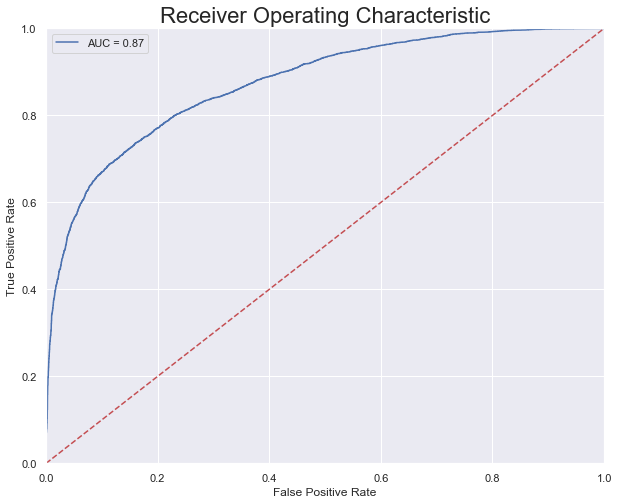

In [121]:
plt.figure(figsize = (10,8))
plt.title('Receiver Operating Characteristic',fontsize = 22)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

In [122]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = threshold[optimal_idx]
optimal_threshold

0.47405447898879943

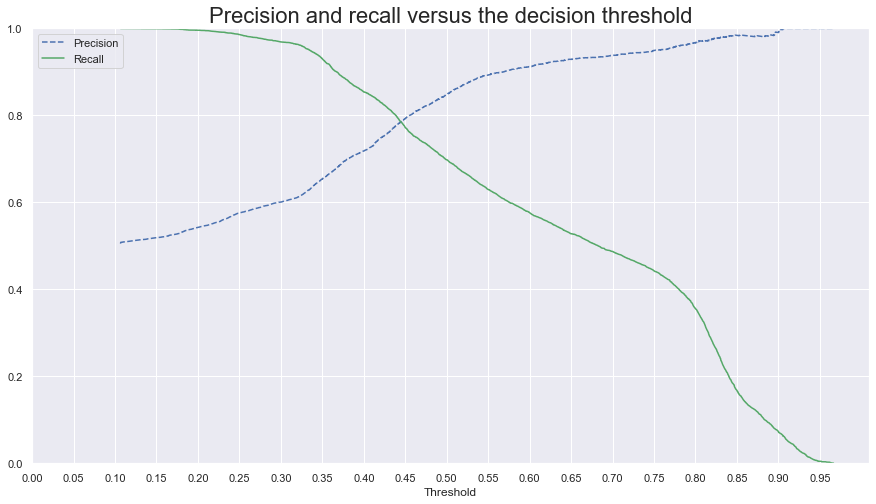

In [124]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize = (15,8))
    plt.title('Precision and recall versus the decision threshold',fontsize = 22)
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.xticks(np.arange(0,1, 0.05))
    plt.ylim([0, 1])
    
precisions, recalls, thresholds = precision_recall_curve(y_under, y_pred)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

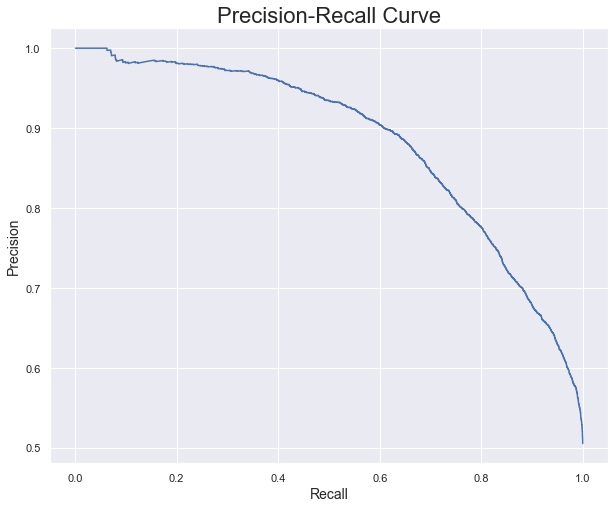

In [125]:
def PrecisionRecall(precisions, recalls, thresholds):
    plt.figure(figsize = (10,8))
    plt.title('Precision and recall versus the decision threshold')
    plt.plot(recalls[:-1], precisions[:-1], "b-")
    plt.xlabel('Recall', fontsize = 14)
    plt.ylabel('Precision', fontsize = 14)
    plt.title('Precision-Recall Curve', fontsize = 22)
    
precisions, recalls, thresholds = precision_recall_curve(y_under, y_pred)
PrecisionRecall(precisions, recalls, thresholds)
plt.show()

In [127]:
#confusion_matrix(y_under, y_pred)

In [128]:
#precision_score(y_under, y_pred)
#recall_score(y_under, y_pred)

In [129]:
random_final.classes_

array([0, 1])

In [137]:
estimator = random_final.estimators_[6]

In [139]:
from sklearn.tree import export_graphviz
fn = X_train.columns.tolist()
cn = ['No-Injuries', 'Injuries']
# Export as dot file
tree.export_graphviz(estimator, class_names=cn,
                feature_names=fn,
                out_file='tree.dot', 
                rounded = True, proportion = False, 
                precision = 2, filled = True)

In [140]:
# Convert dot file into png
!dot -Tpng -Gdpi=800 tree.dot -o tree_1.png

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.192483 to fit


In [144]:
train.info()
# avoinding to change to many things down. Therefore
train_new=train.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54388 entries, 0 to 54387
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   CRASH_DATE               54388 non-null  datetime64[ns]
 1   POSTED_SPEED_LIMIT       54388 non-null  int64         
 2   TRAFFIC_CONTROL_DEVICE   54388 non-null  object        
 3   DEVICE_CONDITION         54388 non-null  object        
 4   WEATHER_CONDITION        54388 non-null  object        
 5   LIGHTING_CONDITION       54388 non-null  object        
 6   FIRST_CRASH_TYPE         54388 non-null  object        
 7   TRAFFICWAY_TYPE          54388 non-null  object        
 8   LANE_CNT                 54388 non-null  int64         
 9   ALIGNMENT                54388 non-null  object        
 10  ROADWAY_SURFACE_COND     54388 non-null  object        
 11  ROAD_DEFECT              54388 non-null  object        
 12  INTERSECTION_RELATED_I   54388 n

Text(0, 0.5, 'Density')

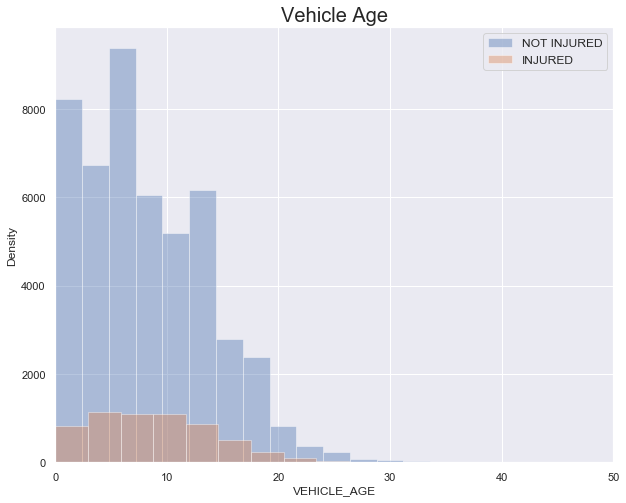

In [158]:
plt.figure(figsize = (10,8))
df = train_new[(train_new.INJURY == 'NOT INJURED') & (train_new.VEHICLE_AGE < 50)]
sns.distplot(df['VEHICLE_AGE'], bins=20, kde=False, label='NOT INJURED')

df =train_new[(train_new.INJURY == 'INJURED')]
sns.distplot(df['VEHICLE_AGE'], bins=40, kde=False,label='INJURED')

# Plot formatting
plt.legend(prop={'size': 12})
plt.xlim([0, 50])
plt.title('Vehicle Age',fontsize=20)
plt.xlabel('VEHICLE_AGE')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

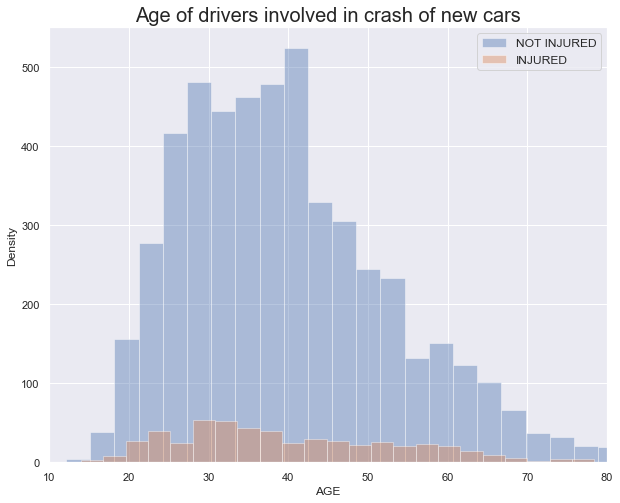

In [160]:
plt.figure(figsize = (10,8))
df =train_new[(train_new.INJURY == 'NOT INJURED') & (train.VEHICLE_AGE.isin(range(0,2)))]
sns.distplot(df['AGE'], bins=30, kde=False,label='NOT INJURED')

df =train_new[(train_new.INJURY == 'INJURED') & (train.VEHICLE_AGE.isin(range(0,2)))]
sns.distplot(df['AGE'], bins=30, kde=False,label='INJURED')

# Plot formatting
plt.legend(prop={'size': 12})
plt.title('Age of drivers involved in crash of new cars',fontsize=20)
plt.xlim([10, 80])
plt.xlabel('AGE')
plt.ylabel('Density')

In [176]:
X_under

scaled_AGE  scaled_LANE_CNT  scaled_POSTED_SPEED_LIMIT  \
0        0.467032        -0.217079                   0.240729   
1       -1.354068        -0.217079                  -2.252280   
2        0.321344         2.413016                   0.240729   
3        0.175656        -0.217079                   0.240729   
4       -0.698472        -0.217079                   0.240729   
...           ...              ...                        ...   
11779   -1.062692        -0.217079                   0.240729   
11780    0.248500        -0.217079                   0.240729   
11781   -0.698472        -0.217079                   0.240729   
11782   -0.917004        -1.532126                   0.240729   
11783    1.122628        -0.217079                   0.240729   

       scaled_NUM_UNITS  scaled_VEHICLE_AGE  AIRBAG_DEPLOYED_DEPLOYED  \
0             -0.244074            0.484726                         0   
1             -0.244074           -1.441059                         0   
2             -0.244074            1.009940                         0   
3             -0.244074            2.410511                         0   
4             -0.244074           -0.915845                         0   
...                 ...                 ...                       ...   
11779         -0.244074           -0.740773                         0   
11780         -0.244074            2.060369                         0   
11781         -0.244074            0.134584                         0   
11782         -0.244074           -0.565702                         0   
11783         -0.244074            0.834869                         0   

       AIRBAG_DEPLOYED_NOT DEPLOYED  PRIM_CONTRIBUTORY_CAUSE_ANIMAL  \
0                                 0                               0   
1                                 1                               0   
2                                 0                               0   
3                                 0                               0   
4                                 0                               0   
...                             ...                             ...   
11779                             0                               0   
11780                             1                               0   
11781                             0                               0   
11782                             1                               0   
11783                             1                               0   

       PRIM_CONTRIBUTORY_CAUSE_BICYCLE ADVANCING LEGALLY ON RED LIGHT  \
0                                                      0                
1                                                      0                
2                                                      0                
3                                                      0                
4                                                      0                
...                                                  ...                
11779                                                  0                
11780                                                  0                
11781                                                  0                
11782                                                  0                
11783                                                  0                

       PRIM_CONTRIBUTORY_CAUSE_DISREGARDING ROAD MARKINGS  \
0                                                      0    
1                                                      0    
2                                                      0    
3                                                      0    
4                                                      0    
...                                                  ...    
11779                                                  0    
11780                                                  0    
11781                                                  0    
11782    

In [ ]:
from sklearn.inspection import plot_partial_dependence

fig = plt.figure(figsize = (15,8))
plot_partial_dependence(random_final, features = ['scaled_AGE'], # column numbers of plots we want to show
                        X = X_under,
                        fig = fig) # number of values to plot on x axis

plt.show()

In [ ]:
from sklearn.inspection import plot_partial_dependence

fig = plt.figure(figsize = (15,8))
plot_partial_dependence(random_final, features = ['POSTED_SPEED_LIMIT'], # column numbers of plots we want to show
                        X = X_under,
                        fig = fig) # number of values to plot on x axis

plt.show()

In [ ]:
from sklearn.inspection import plot_partial_dependence

fig = plt.figure(figsize = (15,8))
plot_partial_dependence(random_final, features = ['LANE_CNT'], # column numbers of plots we want to show
                        X = X_under,
                        fig = fig) # number of values to plot on x axis

plt.show()

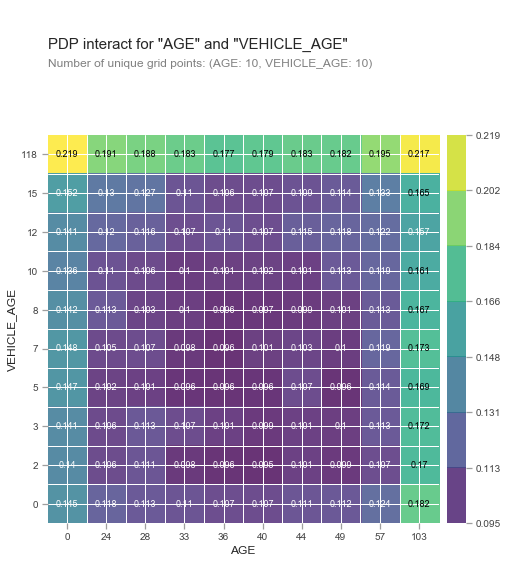

In [386]:
from pdpbox import pdp, get_dataset, info_plots

inter1 = pdp.pdp_interact(
    model = clf, dataset = X_train, model_features = X_train.columns.tolist(), features=['AGE', 'VEHICLE_AGE'])

fig, axes = pdp.pdp_interact_plot(inter1, ['AGE', 'VEHICLE_AGE'], plot_type='grid',  plot_pdp = False)

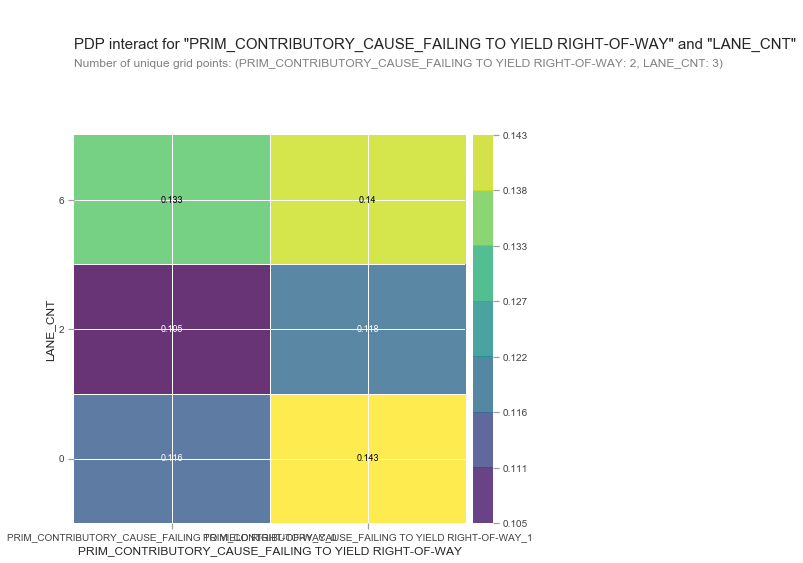

In [387]:
from pdpbox import pdp, get_dataset, info_plots

inter1 = pdp.pdp_interact(
    model = clf, dataset = X_train, model_features = X_train.columns.tolist(), features=['PRIM_CONTRIBUTORY_CAUSE_FAILING TO YIELD RIGHT-OF-WAY', 'LANE_CNT'])

fig, axes = pdp.pdp_interact_plot(inter1, ['PRIM_CONTRIBUTORY_CAUSE_FAILING TO YIELD RIGHT-OF-WAY', 'LANE_CNT'], plot_type='grid',  plot_pdp = False)

### Primary Cause - DISREGARDING TRAFFIC SIGNALS

- Here we can see that 20% of total injury crashes were caused because of **"DISREGARDING TRAFFIC SIGNALS"**

- This figure is 4 times compared to Non-injury crashes.

**Solution:**
- Have heavy penalty for such cases

In [179]:
df=train_new
x,y = 'PRIM_CONTRIBUTORY_CAUSE', 'INJURY'

df1 = df.groupby(y)[x].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('Percent').reset_index()
df1 = df1[df1["PRIM_CONTRIBUTORY_CAUSE"]=="DISREGARDING TRAFFIC SIGNALS"]

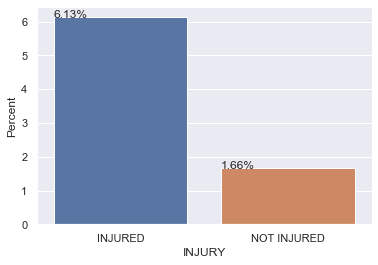

In [180]:
ax = sns.barplot(x="INJURY", y="Percent", data=df1)
for p in ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    ax.text(txt_x,txt_y,txt)

### Primary Cause - FAILING TO YIELD RIGHT-OF-WAY

- Here we can see that 20% of total injury crashes were caused because of **"FAILING TO YIELD RIGHT-OF-WAY"**

- This figure is double compared to Non-injury crashes.

**Solution:**
- Put traffic control Signal

In [181]:
df=train_new
x,y = 'PRIM_CONTRIBUTORY_CAUSE', 'INJURY'

df1 = df.groupby(y)[x].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('Percent').reset_index()
df1 = df1[df1["PRIM_CONTRIBUTORY_CAUSE"]=="FAILING TO YIELD RIGHT-OF-WAY"]

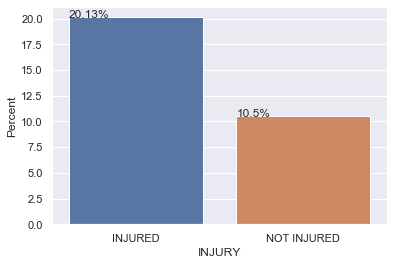

In [182]:
ax = sns.barplot(x="INJURY", y="Percent", data=df1)
for p in ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    ax.text(txt_x,txt_y,txt)

### Primary Cause - FAILING TO REDUCE SPEED TO AVOID CRASH

- Here we can see that 20% of total injury crashes were caused because of **"FAILING TO REDUCE SPEED TO AVOID CRASH"**

- This figure is 2 times compared to Non-injury crashes.

**Solution:**
- Have compulsory ABS system in vehicles

In [183]:
df=train_new
x,y = 'PRIM_CONTRIBUTORY_CAUSE', 'INJURY'

df1 = df.groupby(y)[x].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('Percent').reset_index()
df1 = df1[df1["PRIM_CONTRIBUTORY_CAUSE"]=="FAILING TO REDUCE SPEED TO AVOID CRASH"]

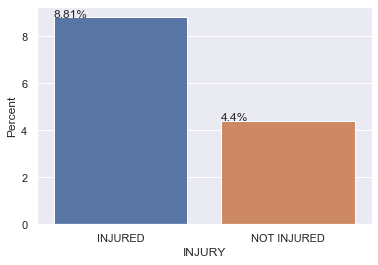

In [184]:
ax = sns.barplot(x="INJURY", y="Percent", data=df1)
for p in ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    ax.text(txt_x,txt_y,txt)

### Airbag deployment and Injuries

- Here we can see that in 20% of total injury crashes were caused when **AIRBAGS were deployed** compared to 3% of Non-injury

- This figure represents that the airbags were not able to stop serious injuries or maybe inefficient Airbag deployments must have caused injuries

**Solution:**
- Check into Airbags and related regulation of Car companies

In [185]:
df=train_new
x,y = 'AIRBAG_DEPLOYED', 'INJURY'

df1 = df.groupby(y)[x].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()
df1 = df1[df1["AIRBAG_DEPLOYED"]=="DEPLOYED"]

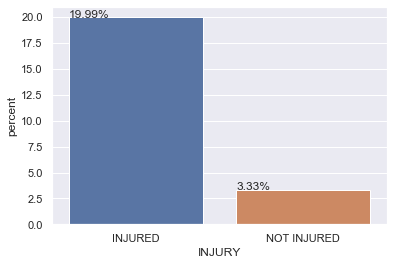

In [186]:
ax = sns.barplot(x="INJURY", y="percent", data=df1)
for p in ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    ax.text(txt_x,txt_y,txt)
    

## Random Forest -Classifier (Fatalities)

In [ ]:
filter_list=["AIRBAG_DEPLOYED","PRIM_CONTRIBUTORY_CAUSE","SEC_CONTRIBUTORY_CAUSE","VEHICLE_AGE","Location","FATALITIES"]

train_new = train[filter_list]

In [ ]:
# splitting the dataset into x_train and y_train
X_train = train_new.drop(["FATALITIES"],axis=1)
y_train = train_new["FATALITIES"]

In [ ]:
#X_train.info()

In [ ]:
# performing one hot encoding on all the object features
X_train = pd.get_dummies(X_train, columns=X_train.select_dtypes(['object']).columns, drop_first=True)

In [ ]:
X_train.shape

In [ ]:
#Encode the y_train labels
lb = preprocessing.LabelBinarizer()
y_train=lb.fit_transform(y_train)

In [ ]:
#Create a Random Forest Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
scores = cross_val_score(clf, X_train, y_train, cv=5)
print('Accuracy', np.mean(scores), scores)

In [ ]:
recall = cross_val_score(clf, X_train, y_train, cv=5, scoring='recall')
print('Recall', np.mean(recall), recall)
precision = cross_val_score(clf, X_train, y_train, cv=5, scoring='precision')
print('Precision', np.mean(precision), precision)
f1 = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1')
print('F1', np.mean(f1), f1)

In [ ]:
#Create a Random Forest Classifier
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)
print(clf.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [ ]:
df=train_new
x,y = 'PRIM_CONTRIBUTORY_CAUSE', 'FATALITIES'

df1 = df.groupby(y)[x].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()
df1 = df1[df1["PRIM_CONTRIBUTORY_CAUSE"]=="PHYSICAL CONDITION OF DRIVER"]
df1

In [ ]:
ax = sns.barplot(x="FATALITIES", y="percent", data=df1)
for p in ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    ax.text(txt_x,txt_y,txt)
    

In [ ]:
df=train_new
x,y = 'AIRBAG_DEPLOYED', 'FATALITIES'

df1 = df.groupby(y)[x].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()
df1 = df1[df1["AIRBAG_DEPLOYED"]=="DEPLOYED"]

In [ ]:
ax = sns.barplot(x="FATALITIES", y="percent", data=df1)
for p in ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    ax.text(txt_x,txt_y,txt)
    

In [ ]:
from sklearn.inspection import plot_partial_dependence

fig = plt.figure(figsize = (15,8))
plot_partial_dependence(clf, features = ['VEHICLE_AGE'], # column numbers of plots we want to show
                        X = X_train,
                        fig = fig) # number of values to plot on x axis

plt.show()

In [ ]:
df = train_new[train_new.FATALITIES == 'NOT FATAL']
sns.distplot(df['VEHICLE_AGE'],  kde=False, label='NOT FATAL')

df =train_new[train_new.FATALITIES == 'FATAL']
sns.distplot(df['VEHICLE_AGE'],  kde=False,label='FATAL')

# Plot formatting
plt.legend(prop={'size': 12})
plt.title('Life Expectancy of Two Continents')
plt.xlabel('VEHICLE_AGE)')
plt.ylabel('Density')